In [108]:
# Intro - I run. This new shoe technology really changed the game in 2020/2021
# 	Road shoes tech moving to track and field 
# Motiv - Super interesting to me personally, lots of anecdotal evidence personally and those I know.
# 	Fun challenge to try to quantify the impact.
# Data - 	NCAA TFRRS archive 2010-2021 excl 2020 for covid.
# 	Reg season top 100 performances. 
# 	Running events. 
# 	Male and Female. D I,II and III.
# Method-	2x2 DiD. Pre-post treated-untreated parallel trends.
# 	Use sprinting as control because 
# Results-Find an average effect of 3% stat signif.
# Limit - Strength of assumptions
# 	More appropriate model
# 	More/Better data
# 	Robustness checks?
# Concl.-	This result is in the ball park of other estimates and what we saw on the roads.


# How Super are the Super Shoes in Track and Field? <br>Exploring NCAA Historical Data and a DiD Approach.

In [1]:
from IPython.display import Image

## What are 'Super Shoes'?

### Every sport reckons with advances in technology changing the game, whether it be bouyant swim suits, alloy  bats in baseball, astro turf fields, etc.  In 2017, the road racing scene was turned upside down by the release of Nike's new carbon plated foamy racing show. 

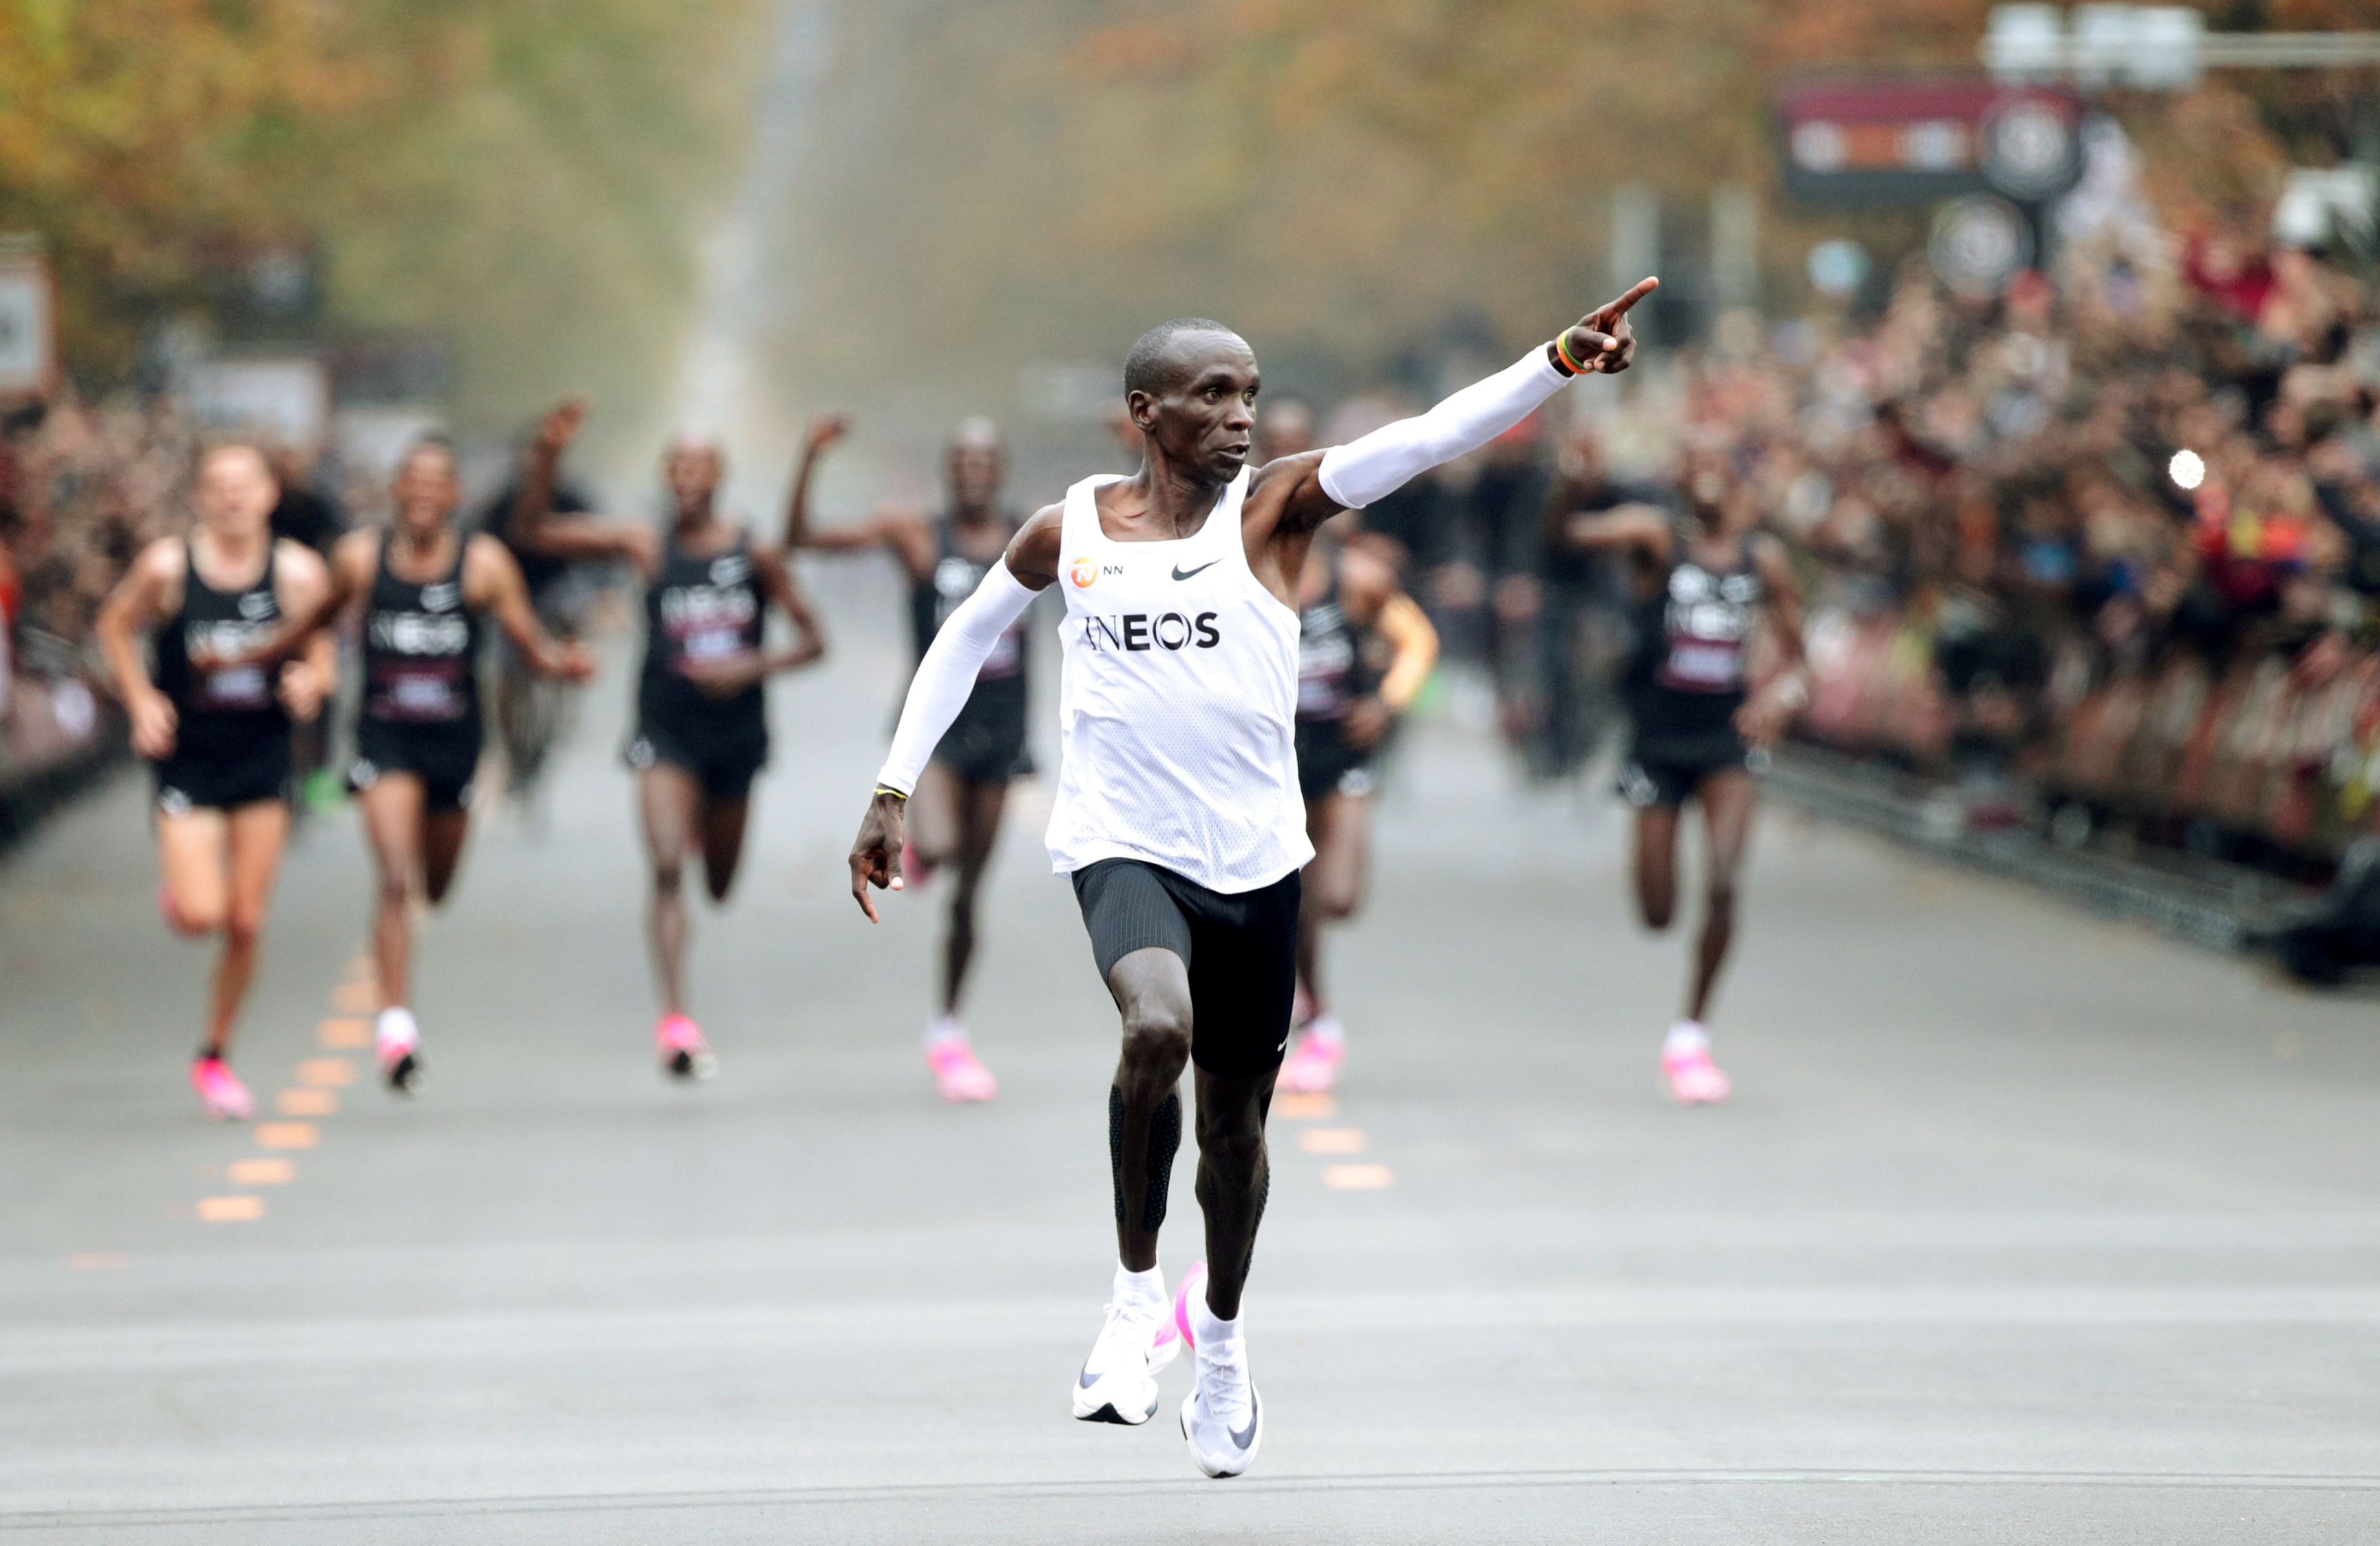

In [2]:
Image(filename='kipchoge_winning.png')

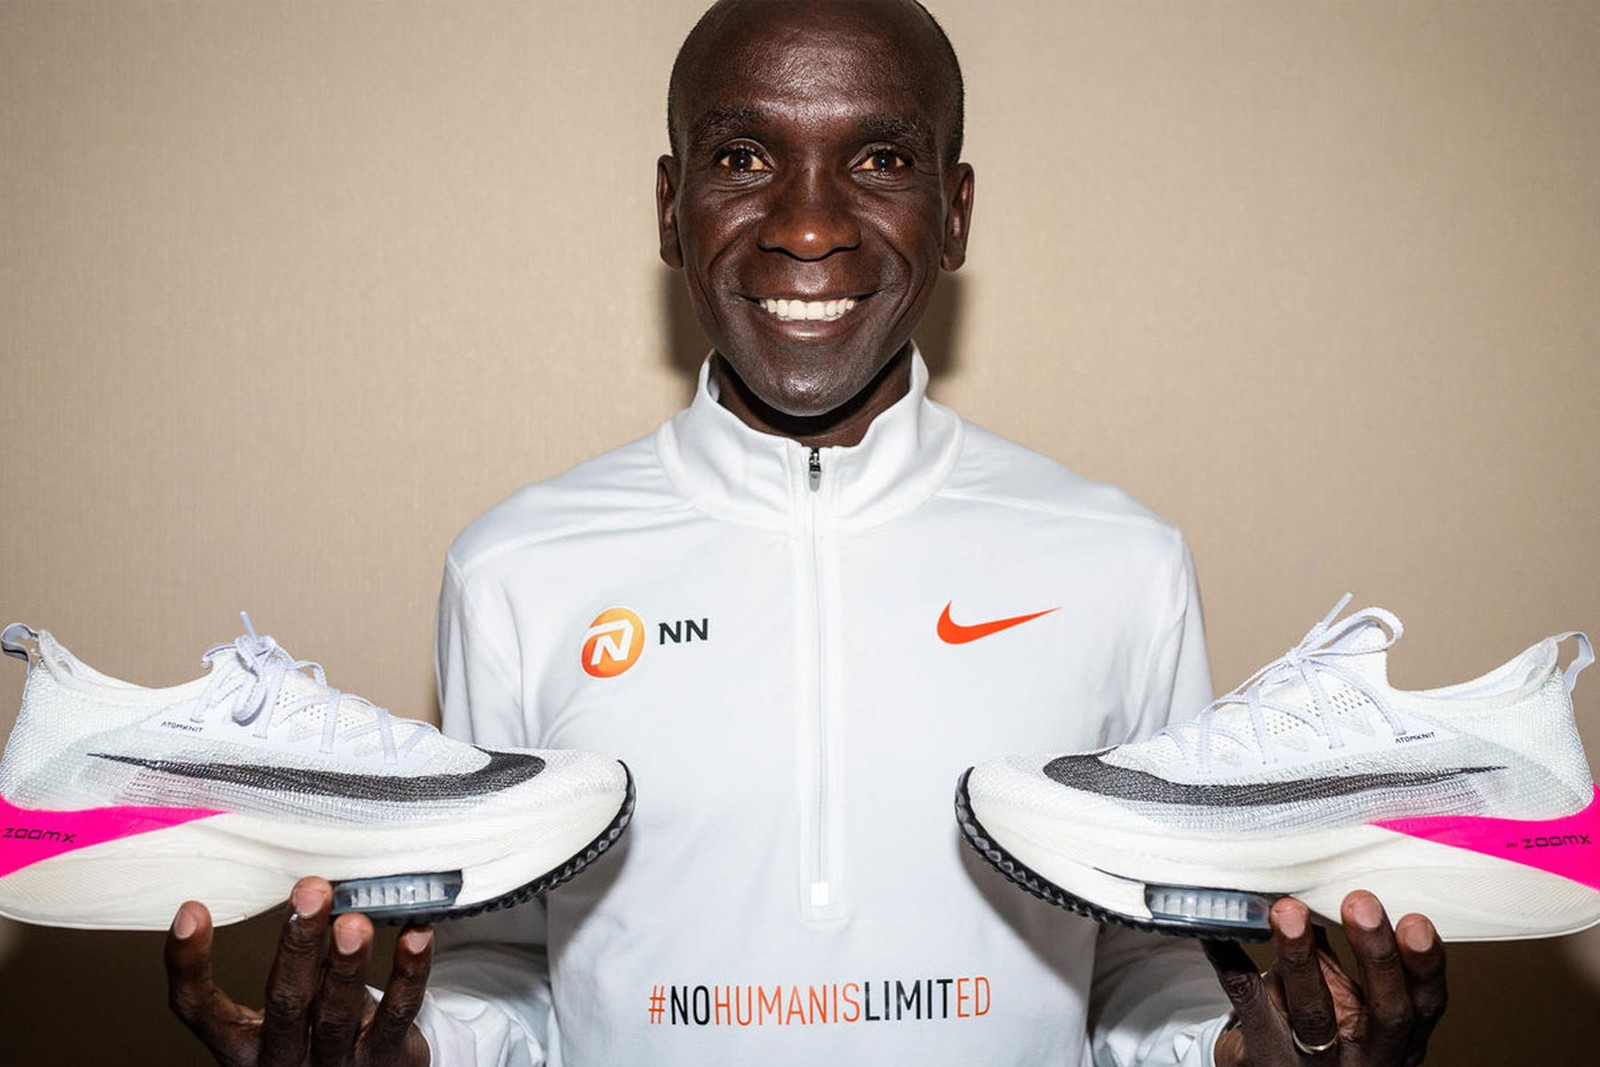

In [3]:
Image(filename='kipchoge.png')

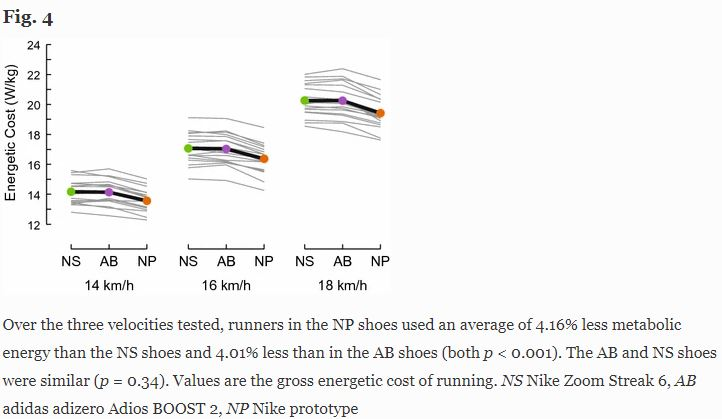

In [4]:
Image(filename='4_percent.png')

source: https://link.springer.com/article/10.1007%2Fs40279-017-0811-2

## Thus the name 'Nike 4%' was born. Regulators took some time to catch up to the new technology, but the rulebook has been rewritten and now the other major players in running shoes have comparable road racing shoes on the market.  

### Old Spikes

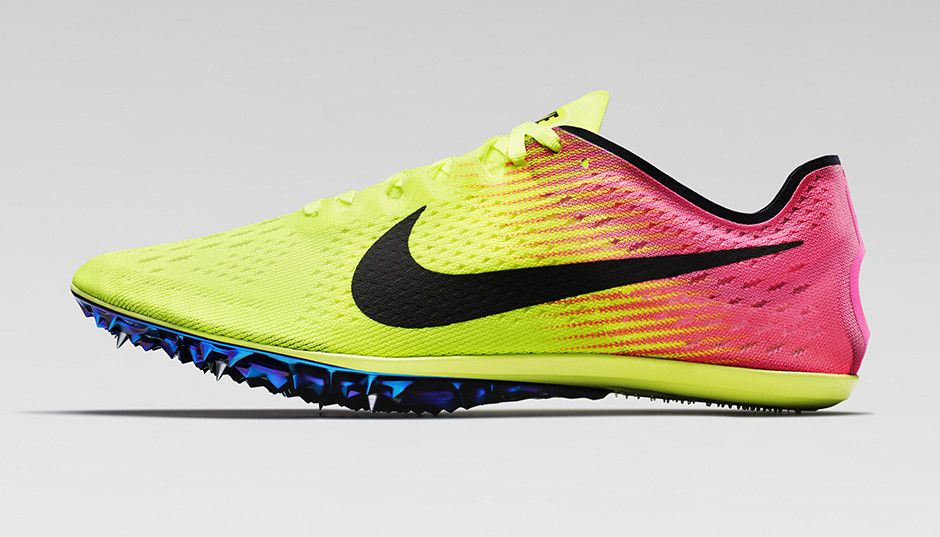

In [5]:
Image(filename='nike_zoom_vic.png')

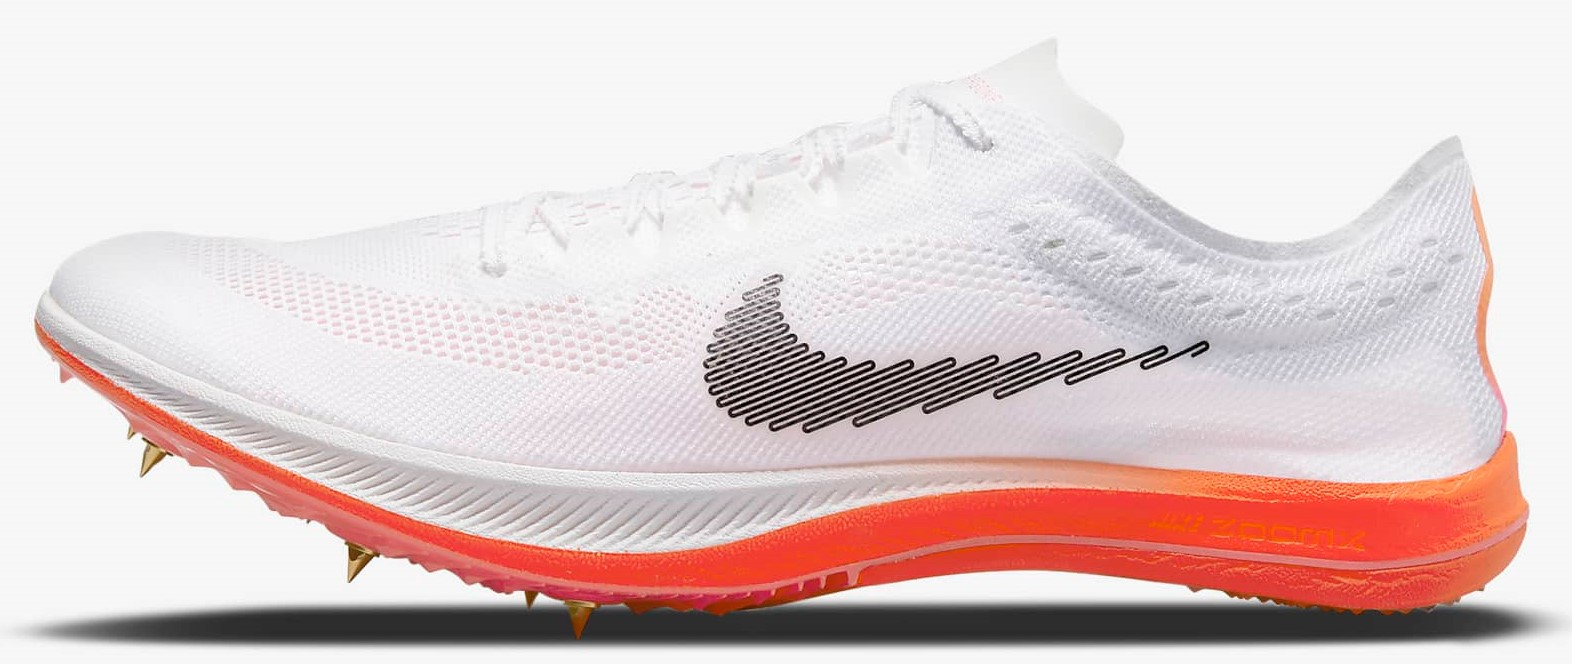

In [6]:
Image(filename='zoomx_1.png')

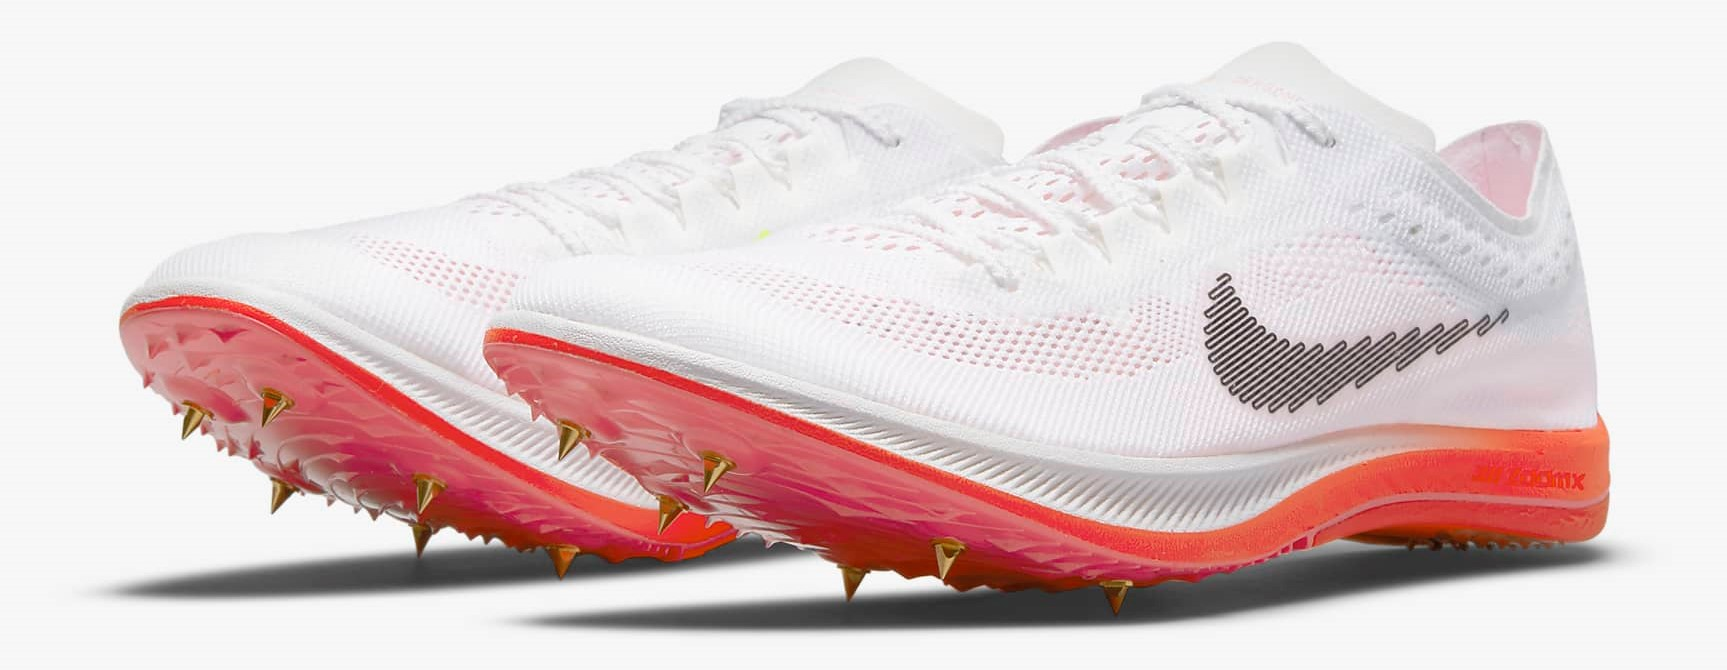

In [7]:
Image(filename='zoomx_2.png')

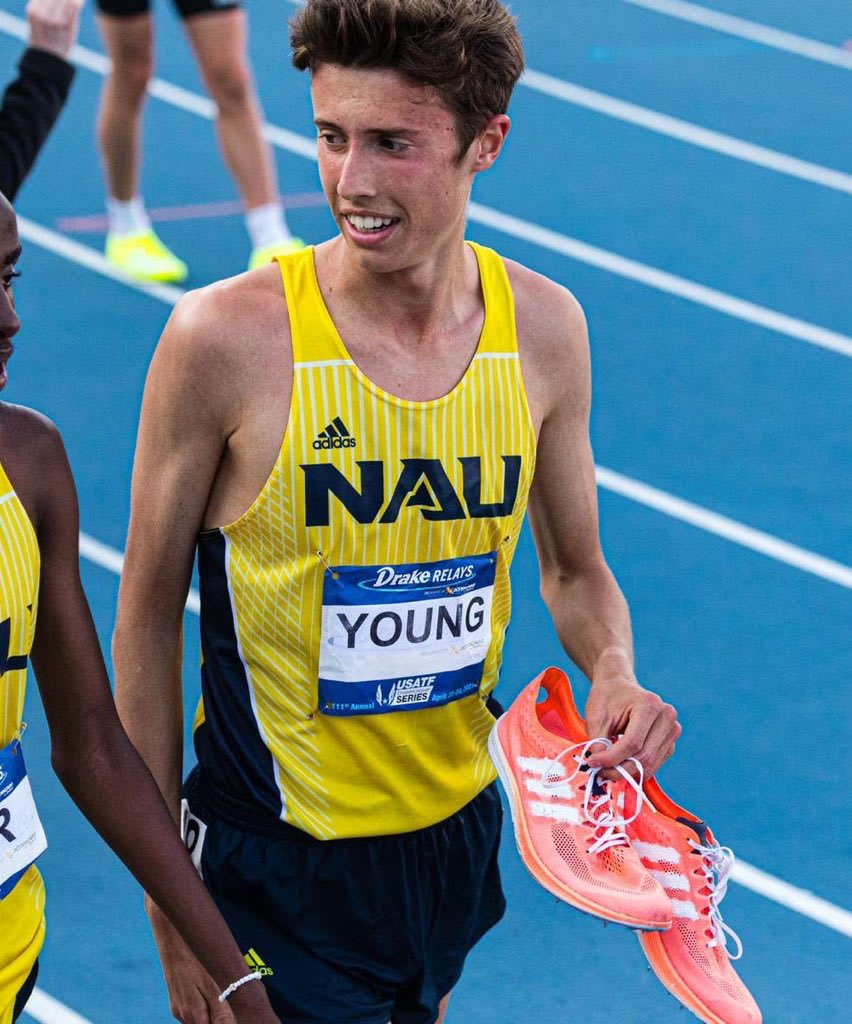

In [8]:
Image(filename='nau_adi_spike.png')

## Data
Data is gathered from the TFRRS.org archive.  Includes data from 2010-2021 (excluding 2020) for top 100 regular season performances for each running event contested for men and women in Division I, II and III. 

In [223]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import ks_2samp
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm
import datetime
import itertools

import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [224]:
# https://www.youtube.com/watch?v=EgIU1_qZ5Lcabs

In [225]:
# read in data from csv and convert column names to str
df100 = pd.read_csv('tfrrs_scraped.csv')

In [226]:
# keep only running events
running_events = ['100', '200', '400', '800', '1500', '5000', '10000', '100H',
       '110H', '400H', '3000S', '4x100', '4x400']
df100 = df100[df100['EVENT'].isin(running_events)]

In [227]:
df100.head()

POSITION  CHAMP_YEAR DIVISION EVENT  SEX             ATHLETE  YEAR  \
0         1        2021       D1   100  Men     Laird, Terrance  JR-3   
1         2        2021       D1   100  Men  Maswanganyi, Shaun  FR-1   
2         3        2021       D1   100  Men    Martin, JoVaughn  SO-2   
3         4        2021       D1   100  Men     Boling, Matthew  FR-1   
4         5        2021       D1   100  Men       Amoah, Joseph  SR-4   

            TEAM   TIME  TIME_SECS MARK CONV  POINTS  \
0            LSU   9:80       9.80  NaN  NaN     NaN   
1        Houston   9:87       9.87  NaN  NaN     NaN   
2  Florida State   9:94       9.94  NaN  NaN     NaN   
3        Georgia   9:97       9.97  NaN  NaN     NaN   
4   Coppin State  10:00      10.00  NaN  NaN     NaN   

                                               MEET     MEET DATE  
0           SEC Outdoor Track & Field Championships  May 13, 2021  
1  The American Outdoor Track & Field Championships  May 14, 2021  
2                         UF Tom Jones Invitational  Apr 16, 2021  
3           SEC Outdoor Track & Field Championships  May 13, 2021  
4                           2021 Aggie Invitational  Apr 10, 2021

In [228]:
# create new df. For each year/division/event/sex group, get the average time_secs for that group in each year

# list of groups and avg time_secs
avg_list = []
for group in df100.groupby(['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX']):
    avg_list.append([group[0], group[1].TIME_SECS.mean()])
    
# split group tuple back into year/division/event/sex columns and drop group tuple
df_grouped = pd.DataFrame(avg_list, columns = ['GROUP', 'TIME_SECS_AVG'])
df_grouped[['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX']] = pd.DataFrame(df_grouped['GROUP'].tolist(), index=df_grouped.index)
df_grouped = df_grouped[['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX', 'TIME_SECS_AVG']]

In [229]:
# list of dfs for each division/event/sex group
df_list = [group[1].reset_index() for group in df_grouped.groupby(['DIVISION', 'EVENT', 'SEX'])]

# for each df, rescale the TIME_SECS column by dividing all by the 2010 avg
avg_2010 = [df['TIME_SECS_AVG'][0] for df in df_list]
for df,avg in zip(df_list,avg_2010):
    df['TIME_SECS_SCALED'] = df['TIME_SECS_AVG']/avg
    
# concat back into one df
df_scaled = pd.concat(df_list).reset_index()
df_scaled.drop(['level_0','index'], axis=1, inplace=True)

In [230]:
# add treat, after and treatafter variable to the df
distance = ['800', '1500', '5000', '10000', '3000SC']
treat_list = [1 if event in distance else 0 for event in df_scaled['EVENT']]
df_scaled['TREAT'] = treat_list
df_scaled['AFTER'] = df_scaled['CHAMP_YEAR'] >= 2021
df_scaled['TREAT_AFTER'] = df_scaled['AFTER']*df_scaled['TREAT']

In [231]:
df_scaled

CHAMP_YEAR DIVISION EVENT    SEX  TIME_SECS_AVG  TIME_SECS_SCALED  TREAT  \
0          2010       D1   100    Men        10.3757          1.000000      0   
1          2011       D1   100    Men        10.3272          0.995326      0   
2          2012       D1   100    Men        10.3192          0.994555      0   
3          2013       D1   100    Men        10.3453          0.997070      0   
4          2014       D1   100    Men        10.3080          0.993475      0   
..          ...      ...   ...    ...            ...               ...    ...   
787        2016       D3   800  Women       133.7330          0.992632      1   
788        2017       D3   800  Women       134.2192          0.996241      1   
789        2018       D3   800  Women       134.5749          0.998881      1   
790        2019       D3   800  Women       135.0592          1.002475      1   
791        2021       D3   800  Women       135.4539          1.005405      1   

     AFTER  TREAT_AFTER  
0    False            0  
1    False            0  
2    False            0  
3    False            0  
4    False            0  
..     ...          ...  
787  False            0  
788  False            0  
789  False            0  
790  False            0  
791   True            1  

[792 rows x 9 columns]

In [326]:
# group into treated and control, find avg time_secs_scaled for each year and plot against oneanother
t = []
c = []

treat_df = df_scaled[df_scaled['TREAT'] == 1]
control_df = df_scaled[df_scaled['TREAT'] == 0]

for group in control_df.groupby('CHAMP_YEAR'):
    t.append([group[0], group[1]['TIME_SECS_SCALED'].mean()])

for group in treat_df.groupby('CHAMP_YEAR'):
    c.append([group[0], group[1]['TIME_SECS_SCALED'].mean()])

In [327]:
t

[[2010, 1.0],
 [2011, 0.9957601318609579],
 [2012, 0.992087159075563],
 [2013, 0.9938360661551403],
 [2014, 0.9919700343097421],
 [2015, 0.989411861289604],
 [2016, 0.9884325045499874],
 [2017, 0.9871449203038362],
 [2018, 0.9874002566190762],
 [2019, 0.9880978698529989],
 [2021, 0.9914417135294156]]

In [328]:
c

[[2010, 1.0],
 [2011, 0.998677853012397],
 [2012, 0.9949191094196396],
 [2013, 0.9952959143711779],
 [2014, 0.9931986115233479],
 [2015, 0.9925874565863936],
 [2016, 0.9905779905671235],
 [2017, 0.9906741074609834],
 [2018, 0.991119044458545],
 [2019, 0.9917379016156526],
 [2021, 0.9887708742145022]]

In [288]:
#Model the DiD specification

X = sm.add_constant(df_scaled[['TREAT', 'TREAT_AFTER', 'AFTER']].astype('float'))
y = df_scaled['TIME_SECS_SCALED']

smf_fit = smf.ols('TIME_SECS_SCALED ~ 1 + TREAT + TREAT_AFTER + AFTER', data=df_scaled).fit()

print(smf_fit.summary())

                            OLS Regression Results                            
Dep. Variable:       TIME_SECS_SCALED   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     9.608
Date:                Wed, 22 Sep 2021   Prob (F-statistic):           3.10e-06
Time:                        18:16:28   Log-Likelihood:                 2849.5
No. Observations:                 792   AIC:                            -5691.
Df Residuals:                     788   BIC:                            -5672.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9914      0.000   3270.028

## Interpretation: Treatment(super shoes) are associated with running 0.51% faster than the 2010 average for that division/sex/event group. 

In [280]:
effect = -0.0051
results = []
for group in df_scaled.groupby(['DIVISION', 'EVENT', 'SEX']):
    if group[0][1] in distance:
        group[1].reset_index(inplace=True)
        results.append([group[0], effect*group[1]['TIME_SECS_AVG'][0]])

In [286]:
pd.DataFrame(results, columns=['GROUP', 'SECONDS_FASTER'])

GROUP  SECONDS_FASTER
0     (D1, 10000, Men)       -8.968237
1   (D1, 10000, Women)      -10.578697
2      (D1, 1500, Men)       -1.140562
3    (D1, 1500, Women)       -1.331993
4      (D1, 5000, Men)       -4.252616
5    (D1, 5000, Women)       -4.977871
6       (D1, 800, Men)       -0.555619
7     (D1, 800, Women)       -0.647123
8     (D2, 10000, Men)       -9.491599
9   (D2, 10000, Women)      -11.407628
10     (D2, 1500, Men)       -1.190443
11   (D2, 1500, Women)       -1.413015
12     (D2, 5000, Men)       -4.483167
13   (D2, 5000, Women)       -5.319177
14      (D2, 800, Men)       -0.576154
15    (D2, 800, Women)       -0.687463
16    (D3, 10000, Men)       -9.618879
17  (D3, 10000, Women)      -11.501460
18     (D3, 1500, Men)       -1.198753
19   (D3, 1500, Women)       -1.426505
20     (D3, 5000, Men)       -4.535721
21   (D3, 5000, Women)       -5.401196
22      (D3, 800, Men)       -0.578400
23    (D3, 800, Women)       -0.687101

In [56]:
dist = df100[900:1000]
dist['treat'] = 1
sprint = df100[:100]
sprint['treat'] = 0
did_df = pd.concat([dist, sprint])

<ipython-input-56-fea795895456>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dist['treat'] = 1
<ipython-input-56-fea795895456>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sprint['treat'] = 0


In [59]:
# Step 2: indicator variables 

# whether treatment has occured at all
did_df['after'] = did_df['CHAMP_YEAR'] >= 2021
# whether it has occurred to this entity
did_df['treatafter'] = did_df['after'] * did_df['treat']

### For each unique combination of DIVISION/EVENT/SEX group all years together.

In [13]:
# separate df into 2021 and non 2021 years
df100_2021 = df100[df100['CHAMP_YEAR'] == 2021]
df100 = df100[df100['CHAMP_YEAR'] != 2021]

In [14]:
def regroup_df(df):
    '''group by CHAMP_YEAR DIVISION EVENT SEX'''
    df_group = df.groupby(['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX']).mean()
    group = df_group['TIME_SECS'].groupby(['EVENT', 'DIVISION'], group_keys=False)
    res = group.apply(lambda x: x.sort_values(ascending=[False]))
    
    return pd.DataFrame(res).reset_index()

In [15]:
regroup = regroup_df(df100)

In [16]:
regroup2021 = regroup_df(df100_2021)

### Regression for time trends

In [17]:
# functions to get the slope, coef of determination, pvalue and std errors for two arrays
def reg_slope(X,y):
    '''Return stats.linregress slope for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[0]

def reg_rval(X,y):
    '''Return stats.linregress p-value for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[2]

def reg_pval(X,y):
    '''Return stats.linregress p-value for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[3]

def reg_stderr(X,y):
    '''Return stats.linregress standard error for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[4]

In [18]:
def reg_table(df):
    '''Take top 10 rows of dataframe: regress TIME_SECS on CHAMP_YEAR, predict 2021 and save the results to new df.'''
    results_list = []
    while len(df) > 0:
        
        years = [df.CHAMP_YEAR[i] for i in range(10)]
        means = [df.TIME_SECS[i] for i in range(10)]
        
        slope = reg_slope(years,means)
        rval = reg_rval(years,means)
        pval = reg_pval(years,means)
        std_err = reg_stderr(years,means)
        
        X = np.array(years).reshape(-1, 1)
        y = means

        reg = LinearRegression().fit(X, y)
        pred = reg.predict(np.array(2021).reshape(-1,1))[0]
        
        

        row_result = [str(df.DIVISION[0]), str(df.SEX[0]), str(df.EVENT[0]), slope, rval, pval, means_std, std_err, pred]
        results_list.append(row_result)
        
        df = df.drop(range(0,10))
        df = df.reset_index(drop=True)
    return pd.DataFrame(results_list, columns=['DIVISION', 'SEX', 'EVENT', 'SLOPE', 'R_VAL','P_VAL', 'MEANS_STD', 'STD_ERR', '2021_PRED'])

In [19]:
def pred_interval(means_list, prediction, critical_value = 1.96):
    sum_errs = arraysum((y - yhat)**2)
    stdev = sqrt(1/(len(y)-2) * sum_errs)

In [21]:
# stdev = np.sqrt(1/(len(means)-2) * sum_errs)

In [22]:
sum_errs

NameError: name 'sum_errs' is not defined

In [23]:
stdev

NameError: name 'stdev' is not defined

In [24]:
sum_errs = arraysum((y - yhat)**2)
stdev = sqrt(1/(len(y)-2) * sum_errs)

NameError: name 'arraysum' is not defined

In [25]:
regression_df = reg_table(regroup)

NameError: name 'means_std' is not defined

In [26]:
regression_df.head()

NameError: name 'regression_df' is not defined

In [27]:
regression_df['2021_ACTUAL'] = regroup2021['TIME_SECS']

NameError: name 'regression_df' is not defined

In [28]:
regression_df['PERCENT_DIFF'] = ((regression_df['2021_ACTUAL'] - regression_df['2021_PRED']) / regression_df['2021_PRED'])*100

NameError: name 'regression_df' is not defined

In [29]:
def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    '''
    Get a prediction interval for a linear regression.
    
    INPUTS: 
        - Single prediction, 
        - y_test
        - All test set predictions,
        - Prediction interval threshold (default = .95) 
    OUTPUT: 
        - Prediction interval for single prediction
    '''
    
    #get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    #get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    #generate prediction interval lower and upper bound
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [30]:
get_prediction_interval

<function __main__.get_prediction_interval(prediction, y_test, test_predictions, pi=0.95)>

In [31]:
regression_df['CI_99']

NameError: name 'regression_df' is not defined

In [32]:
regression_df.head()

NameError: name 'regression_df' is not defined

In [33]:
# write to csv
# regression_df.to_csv('trends_table.csv', index=False)

### Group by distance/sprint and run t-test to see if slopes are statistically different.

In [34]:
distance_events = ['10000', '1500', '3000S','5000']
regression_df_distance = regression_df.loc[regression_df['EVENT'].isin(distance_events)]
regression_df_sprint = regression_df.loc[~regression_df['EVENT'].isin(distance_events)]

NameError: name 'regression_df' is not defined

In [35]:
len(regression_df_distance)

NameError: name 'regression_df_distance' is not defined

In [36]:
len(regression_df_sprint)

NameError: name 'regression_df_sprint' is not defined

In [37]:
distance_slope = regression_df_distance.SLOPE
sprint_slope = regression_df_sprint.SLOPE

NameError: name 'regression_df_distance' is not defined

NameError: name 'distance_slope' is not defined

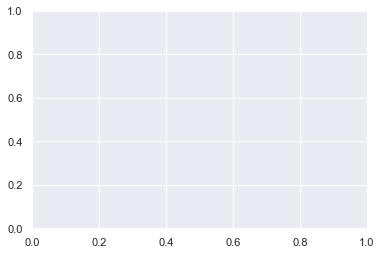

In [38]:
fig, ax = plt.subplots()
ax.hist(distance_slope, label='Distance')
ax.hist(sprint_slope, label='Sprint')
ax.legend(loc='upper left')
plt.show()

In [ ]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [39]:
for i in sprint_slope:
    abline(i, 10)

NameError: name 'sprint_slope' is not defined

In [40]:
regression_df.head()

NameError: name 'regression_df' is not defined

In [41]:
for i in distance_slope:
    abline(i, 10)

NameError: name 'distance_slope' is not defined

In [42]:
sprint_slope.describe()

NameError: name 'sprint_slope' is not defined

In [43]:
distance_slope.describe()

NameError: name 'distance_slope' is not defined

### Two Sample Kolmogorov-Smirnov test

In [44]:
# two random samples of half of the regression_df dataframe and perform a KS-2 Sample test
counter = 20
while counter > 0:
    print(ks_2samp(regression_df.SLOPE.sample(frac=0.5), regression_df.SLOPE.sample(frac=0.5)))
    counter -= 1

NameError: name 'regression_df' is not defined

In [45]:
# Same test but for distance and sprint grouped sub-dfs
ks_2samp(sprint_slope, distance_slope)

NameError: name 'sprint_slope' is not defined

As you can see, KS tests with randomly selected sub-dfs from regression_df produce large p-values, fail to reject the null that they are the same distribution.  But running the KS test comparing distance and sprints the p-value is extremely small. Therefore, the prediction slopes for distance vs sprint events from 2010-2019 are not from the same distribution. 

### Feature Engineering

Create a new column TIME_SCALED so that we can compare changes across time between event division and sex by rescaling each groups times by the average time for that group using 2010 as the base year.  

In [46]:
# transform df100 from long to wide indexed by year and position.  Forward fill (ffill) to propagate nan values from tied position in original df
df100_wide = pd.pivot_table(df100, values=['TIME_SECS'], index=['CHAMP_YEAR', 'POSITION'], columns=['DIVISION', 'EVENT', 'SEX']).fillna(method='ffill')

In [47]:
# find the mean for each group in year 2010 for the base year
mean_2010 = [group for group in df100_wide.groupby('CHAMP_YEAR')][0][1].mean()

In [48]:
# divide each column in df100_wide by the mean_2010 series to get each TIME_SECS rescaled by the 2010 mean.
df100_rescaled = df100_wide.divide(mean_2010, axis=1)

In [49]:
# sort year high to low, position low to high
df100 = df100.sort_index(level=['CHAMP_YEAR', 'POSITION'], ascending=[False, True])

TypeError: ascending must be a list of bool values of length 1

In [50]:
# new variable log of time_secs
df100['LOG_TIME_SECS'] = np.log(df100['TIME_SECS'])

In [51]:
# create dummy dfs for each variable
champ_year_dummy = pd.get_dummies(df100['CHAMP_YEAR'])
division_dummy = pd.get_dummies(df100['DIVISION'])
event_dummy = pd.get_dummies(df100['EVENT'])
sex_dummy = pd.get_dummies(df100['SEX'])

# distance event dummy
distance_events = ['800', '1500', '3000S', '5000', '10000']
df100['DISTANCE'] = [1 if event in distance_events else 0 for event in df100['EVENT']]

# concat dummy dfs to right side of df100_rescaled
df100 = pd.concat([df100, champ_year_dummy, division_dummy, event_dummy, sex_dummy], axis=1)

# treated dummy for years 2021 and after
df100['TREATED'] = df100[2021]

KeyError: 2021

In [ ]:
# make sure column names are strings
df100.columns = df100.columns.astype(str)

In [52]:
df100 = df100.rename(columns={'2010': 'y2010', '2011': 'y2011', '2012': 'y2012', '2013': 'y2013', '2014': 'y2014', '2015': 'y2015',
       '2016': 'y2016', '2017': 'y2017', '2018': 'y2018', '2019': 'y2019', '2021': 'y2021', '100': 'e100', '10000': 'e10000', '100H': 'e100H', '110H': 'e110H', '1500': 'e1500', '200': 'e200', '3000S': 'e3000S', '400': 'e400', '400H': 'e400H',
       '4x100': 'e4x100', '4x400': 'e4x400', '5000': 'e5000', '800': 'e800'})

In [53]:
df100.columns

Index([     'POSITION',    'CHAMP_YEAR',      'DIVISION',         'EVENT',
                 'SEX',       'ATHLETE',          'YEAR',          'TEAM',
                'TIME',     'TIME_SECS',          'MARK',          'CONV',
              'POINTS',          'MEET',     'MEET DATE', 'LOG_TIME_SECS',
            'DISTANCE',            2010,            2011,            2012,
                  2013,            2014,            2015,            2016,
                  2017,            2018,            2019,            'D1',
                  'D2',            'D3',          'e100',        'e10000',
               'e100H',         'e110H',         'e1500',          'e200',
              'e3000S',          'e400',         'e400H',        'e4x100',
              'e4x400',         'e5000',          'e800',           'Men',
               'Women'],
      dtype='object')

In [54]:
# df100.drop(['DT', 'Dec', 'HJ', 'HT', 'Hep', 'JT', 'LJ', 'PV', 'SP', 'TJ'], axis=1, inplace=True)

In [55]:
model = 'TIME_SECS ~ TREATED + DISTANCE + TREATED * DISTANCE + DIVISION + CHAMP_YEAR + EVENT + SEX'

In [56]:
model = 'LOG_TIME_SECS ~ TREATED + DISTANCE + TREATED * DISTANCE'

In [57]:
# DiD specification with clustered standard errors 
mod = smf.ols(formula=model, data=df100)
res = mod.fit()
print(res.summary())

PatsyError: Error evaluating factor: NameError: name 'TREATED' is not defined
    LOG_TIME_SECS ~ TREATED + DISTANCE + TREATED * DISTANCE
                    ^^^^^^^

In [58]:
# sort year high to low, position low to high
df100_rescaled = df100_rescaled.sort_index(level=['CHAMP_YEAR', 'POSITION'], ascending=[False, True])

### Overlapping Histplot of the Distribution for all observations

In [59]:
# for year in df100.CHAMP_YEAR.unique():
#     for i in range(len(df100_rescaled.columns)):
#         plot = df100_rescaled.loc[year][df100_rescaled.columns[i]].hist(alpha=.7)

In [60]:
# champ_year and position columns from index
df100_rescaled = df100_rescaled.reset_index().rename(index={0: 'CHAMP_YEAR', 1: 'POSITION'})

In [61]:
# melt back to long and reorder columns
df100_rescaled = df100_rescaled.melt(id_vars=['POSITION', 'CHAMP_YEAR'])
df100_rescaled = df100_rescaled.rename(columns={'value': 'TIME_SCALED'})
df100_rescaled = df100_rescaled[['CHAMP_YEAR', 'POSITION', 'DIVISION', 'EVENT', 'SEX', 'TIME_SCALED']]

In [62]:
df100_rescaled.head()

CHAMP_YEAR  POSITION DIVISION EVENT  SEX  TIME_SCALED
0        2019         1       D1   100  Men     0.975346
1        2019         2       D1   100  Men     0.976328
2        2019         3       D1   100  Men     0.978290
3        2019         4       D1   100  Men     0.980253
4        2019         5       D1   100  Men     0.983196

In [63]:
# create dummy dfs for each variable
champ_year_dummy = pd.get_dummies(df100_rescaled['CHAMP_YEAR'])
division_dummy = pd.get_dummies(df100_rescaled['DIVISION'])
event_dummy = pd.get_dummies(df100_rescaled['EVENT'])
sex_dummy = pd.get_dummies(df100_rescaled['SEX'])

# distance event dummy
distance_events = ['1500', '5000', '10000']
df100_rescaled['DISTANCE'] = [1 if event in distance_events else 0 for event in df100_rescaled['EVENT']]

# concat dummy dfs to right side of df100_rescaled
df100_rescaled = pd.concat([df100_rescaled, champ_year_dummy, division_dummy, event_dummy, sex_dummy], axis=1)

# treated dummy for years 2021 and after
df100_rescaled['TREATED'] = df100_rescaled[2021]

KeyError: 2021

In [64]:
# make sure column names are strings
df100_rescaled.columns = df100_rescaled.columns.astype(str)

### Specify DiD model
Treated dummy is for DISTANCE, == 1 if distance event that benefits from super shoes. <br>
After intervention dummy is TREATED, == 1 if year 2021 when athletes first gain access to super shoes. <br>
DiD estimate is the interaction DISTANCE * TREATED

In [65]:
model = 'TIME_SCALED ~ DISTANCE + TREATED + DISTANCE * TREATED'

In [66]:
# DiD specification with clustered standard errors 
mod = smf.ols(formula=model, data=df100_rescaled)
res = mod.fit()
print(res.summary())

PatsyError: Error evaluating factor: NameError: name 'TREATED' is not defined
    TIME_SCALED ~ DISTANCE + TREATED + DISTANCE * TREATED
                             ^^^^^^^

In [67]:
df2021 = df100_rescaled[df100_rescaled['CHAMP_YEAR'] == 2021]
dfnot2021 = df100_rescaled[df100_rescaled['CHAMP_YEAR'] != 2021]

df2021_treat = df2021[df2021['DISTANCE'] == 1]
df2021_not_treat = df2021[df2021['DISTANCE'] == 0]

In [68]:
def event_desc_each_year(df, division, sex, event):
    '''Returns a dataframe of summary stats of TIME_SECS for each year for given division, sex and event.  
    Plots a regplot with 95% confidence interval for 2010-2019 mean observations in blue and the 2021 mean observation in red.'''
    
    series_list = []
    for year in df.CHAMP_YEAR.unique():
        df_desc = df[(df['CHAMP_YEAR'] == year) & (df['DIVISION'] == division) & (df['SEX'] == sex) & (df['EVENT'] == event)].TIME_SECS.describe(percentiles=[0.2, 0.4, 0.6, 0.8])        
        series_list.append(df_desc)
        
    result = pd.DataFrame(series_list, index=df.CHAMP_YEAR.unique())
    result['CONVERT'] = [convert_seconds(x) for x in result['mean']]
    
    # plot
    fig, ax = plt.subplots()
    plot = sns.regplot(data = result.reset_index(), x = 'index', y = 'mean', ci=95).set_title(division + ' ' + sex + '\'s ' + event)
    plot.yticks=result['CONVERT']
    
    plt.gcf().set_size_inches(10,6)
    
    # add 2021 mean datapoint to plot as a red dot
    plt.scatter(x=2021, y=mean_event_2021(division, sex, event), color='r')
    return result

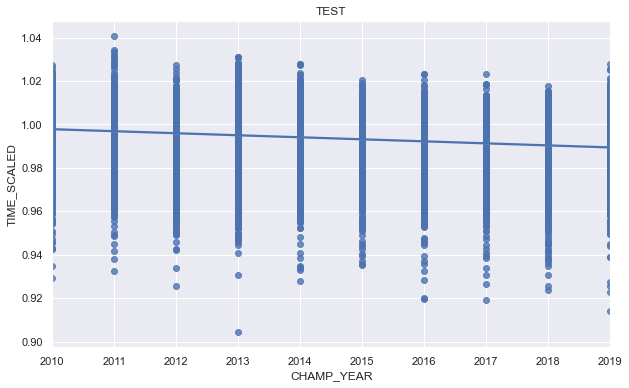

In [69]:
fig, ax = plt.subplots()
plot = sns.regplot(data = dfnot2021, x = 'CHAMP_YEAR', y = 'TIME_SCALED', ci=95).set_title('TEST')
# plot = sns.regplot(data = df2021_not_treat, x = 'CHAMP_YEAR', y = 'TIME_SCALED', ci=95, color='g')
# plot = sns.regplot(data = df2021_treat, x = 'CHAMP_YEAR', y = 'TIME_SCALED', ci=95, color='r')

plt.gcf().set_size_inches(10,6)

# add 2021 mean datapoint for treated and non-treated
plt.scatter(x=2021, y=df2021_not_treat.TIME_SCALED.mean(), color='g')
plt.scatter(x=2021, y=df2021_treat.TIME_SCALED.mean(), color='r')

In [70]:
# add column where each time_secs is normalized by the mean for that event in all years for each sex and division
group = df100.groupby(['SEX', 'DIVISION', 'EVENT', 'CHAMP_YEAR']).TIME_SECS

# divide each time in time_secs by the mean for it's group
# df100['NORM_TIME'] = df100['TIME_SECS'] / group.transform('mean')

In [71]:
test = []
for n, grp in df100.groupby(['SEX', 'DIVISION', 'EVENT']):
    cat = [[i,j] for i, j in zip(grp.CHAMP_YEAR, grp.TIME_SECS)]
    test.append(cat)

### Plot trend of TIME_SECS over time for each event grouped by sex and division

In [72]:
# function to convert seconds to time format
def convert_seconds(secs):
    '''Takes a total number of seconds and returns in %M:%S.%f format'''
    date = datetime.datetime.utcfromtimestamp(secs)
    output = datetime.datetime.strftime(date, "%M:%S.%f")
    return output

In [73]:
# handle a bit differently because men run 110H while women run 100H
men_running_events = ['100', '200', '400', '800', '1500', '5000', '10000',
       '110H', '400H', '3000S', '4x100', '4x400']
women_running_events = ['100', '200', '400', '800', '1500', '5000', '10000', '100H',
       '400H', '3000S', '4x100', '4x400']

In [74]:
df100_2021 = df100[df100['CHAMP_YEAR'] == 2021]
df100_not2021 = df100[df100['CHAMP_YEAR'] != 2021]

In [75]:
# summary stats for TIME_SECS running events
description = df100.groupby(['DIVISION', 'CHAMP_YEAR', 'EVENT', 'SEX'])['TIME_SECS'].describe(percentiles = [.2, .4, .6, .8])
description.sort_values(['DIVISION', 'CHAMP_YEAR', 'EVENT', 'SEX'], ascending=[True, False, True, True], inplace=True)

In [76]:
description

count         mean        std      min  \
DIVISION CHAMP_YEAR EVENT SEX                                             
D1       2019       100   Men     24.0    10.077500   0.068857     9.94   
                          Women   24.0    11.171667   0.099287    10.96   
                    10000 Men     24.0  1716.243750  14.725814  1691.30   
                          Women   24.0  1973.504167  27.121790  1926.71   
                    100H  Women   24.0    12.919167   0.158084    12.55   
...                                ...          ...        ...      ...   
D3       2010       4x400 Women   24.0   232.186667   3.079415   223.54   
                    5000  Men     24.0   872.824167   7.322350   857.10   
                          Women   24.0  1026.725833  12.762824  1001.16   
                    800   Men     24.0   111.562917   0.895387   108.69   
                          Women   24.0   131.420000   1.122524   129.08   

                                      20%       40%       50%       60%  \
DIVISION CHAMP_YEAR EVENT SEX                                             
D1       2019       100   Men      10.026    10.062    10.085    10.098   
                          Women    11.076    11.182    11.195    11.208   
                    10000 Men    1701.768  1709.494  1719.375  1723.394   
                          Women  1944.164  1974.940  1980.775  1989.014   
                    100H  Women    12.732    12.924    12.960    12.988   
...                                   ...       ...       ...       ...   
D3       2010       4x400 Women   230.646   232.134   232.710   233.504   
                    5000  Men     865.856   870.024   874.795   877.554   
                          Women  1019.660  1022.966  1029.455  1031.710   
                    800   Men     111.118   111.674   111.705   111.938   
                          Women   130.522   131.274   131.535   131.622   

                                      80%      max  
DIVISION CHAMP_YEAR EVENT SEX                       
D1       2019       100   Men      10.138    10.17  
                          Women    11.250    11.30  
                    10000 Men    1730.010  1735.27  
                          Women  1996.910  2006.39  
                    100H  Women    13.064    13.10  
...                                   ...      ...  
D3       2010       4x400 Women   234.326   236.44  
                    5000  Men     879.274   882.79  
                          Women  1040.194  1042.81  
                    800   Men     112.318   112.53  
                          Women   132.504   132.92  

[720 rows x 10 columns]

# Visualizations

In [77]:
# queried list of dfs, one for each year

def query_each_year(df, division, sex, event):
    '''Takes df, returns list of dfs for each year with given parameters.'''
    
    results = []
    for year in df.CHAMP_YEAR.unique():
        new_df = df[(df['CHAMP_YEAR'] == year) & (df['DIVISION'] == division) & (df['SEX'] == sex) & (df['EVENT'] == event)]
        results.append(new_df)
    return results

In [78]:
# use queried list of dfs for each year to create a histogram for each year

def histograms_each_year(df, division, sex, event):
    '''Creates a histogram for each df in df_list after query constraints'''
    
    df_list = query_each_year(df, division, sex, event)
    
    for df in df_list:
        fig, ax = plt.subplots()
        plot = df.TIME_SECS.plot(kind='hist', bins=15, ax=ax)
        plot = plot.set_xticklabels(df['TIME'], rotation=20)
        plt.gcf().set_size_inches(8,5)
        pl.suptitle(str(df.CHAMP_YEAR.iloc[0]) + ' ' + df.SEX.iloc[0] + '\'s ' + df.EVENT.iloc[0])

### Example: lets make histograms for D1 men's 1500

<ipython-input-78-f142b2a5509a>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot = plot.set_xticklabels(df['TIME'], rotation=20)


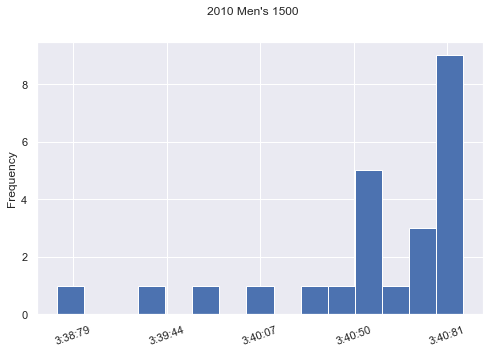

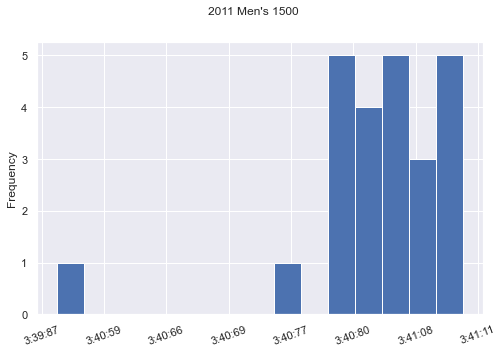

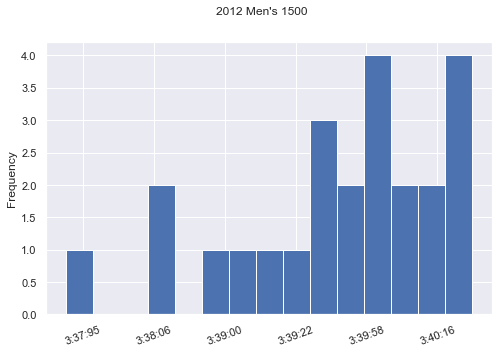

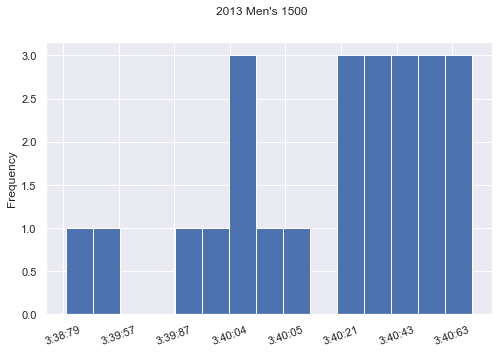

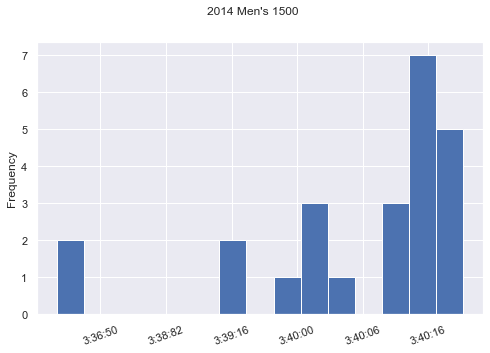

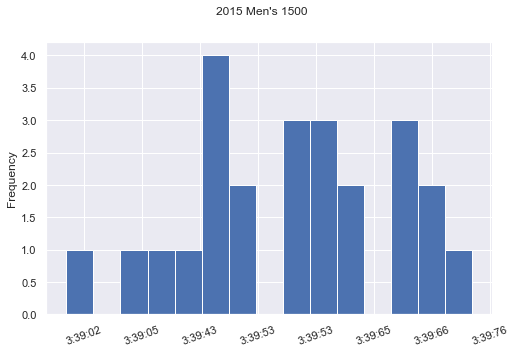

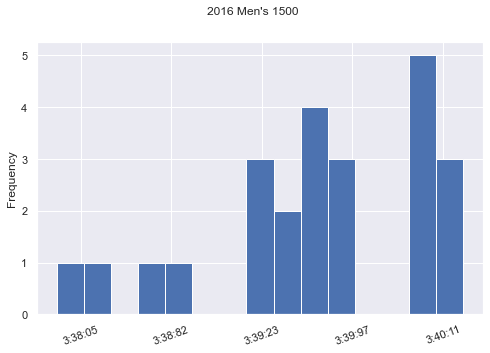

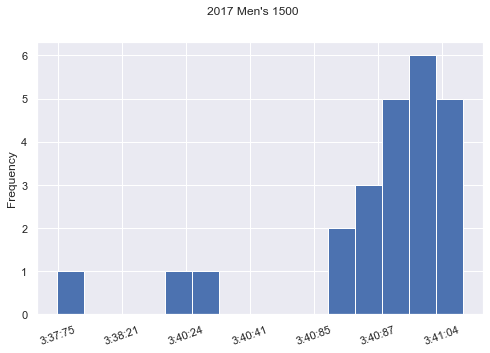

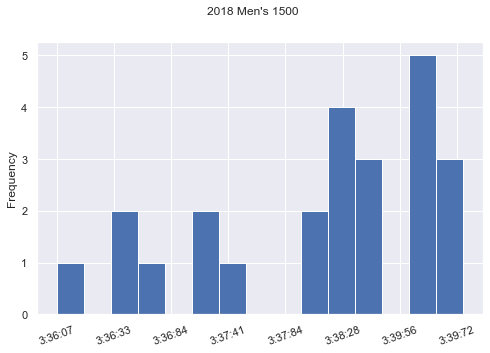

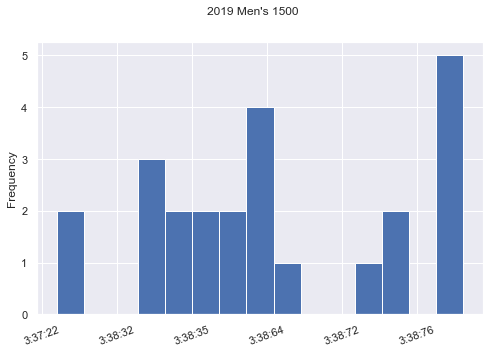

In [79]:
histograms_each_year(df100, 'D1', 'Men', '1500')

In [80]:
def hist_density_overlap(df, division, sex, event):
    '''Creates an overlapping histogram and density for each df in queried list of dfs for each year'''
    
    df_list = query_each_year(df, division, sex, event)
    
    for df in df_list:
        plot = sns.distplot(df.TIME_SECS, kde=True, bins=15, hist=True, label=df.CHAMP_YEAR.iloc[0])
        plot = plot.set_xticklabels(df['TIME'], rotation=20)
        plt.legend()
        plt.gcf().set_size_inches(20,12)
        pl.suptitle(division + ' ' + sex + '\'s ' + event)

C:\Users\Adam\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-80-a4b2f441594b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot = plot.set_xticklabels(df['TIME'], rotation=20)
C:\Users\Adam\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-80-a4b2f441594b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot = plot.set

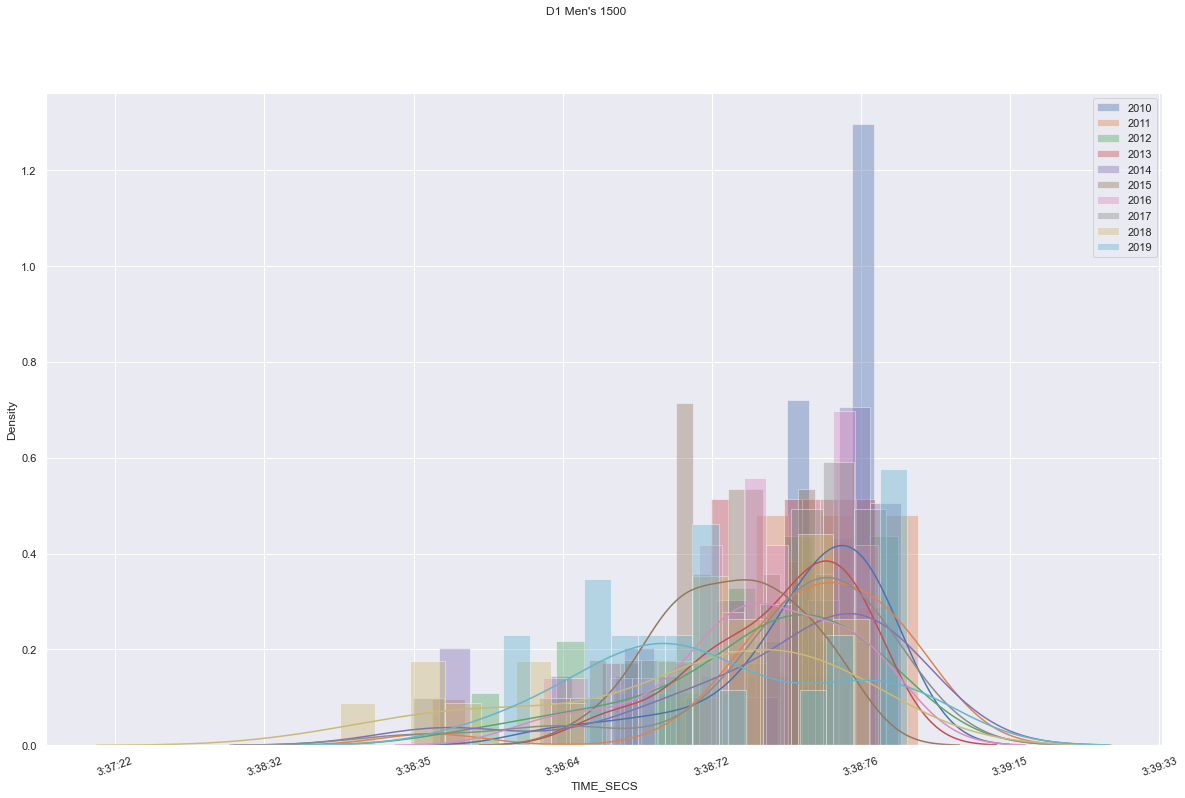

In [81]:
hist_density_overlap(df100, 'D1', 'Men', '1500')

### Take a look at combined distribution across all years for each event division and sex

In [82]:
# queried df, all years, for specified division sex event and 

def query_all_years(df, division, sex, event):
    '''Takes df, returns list of dfs for each year with given parameters.'''
    
    results = df[(df['CHAMP_YEAR'] != 2021) & (df['DIVISION'] == division) & (df['SEX'] == sex) & (df['EVENT'] == event)]
    return results

In [83]:
# histogram for results for given division, sex, event and all years

def histogram_all_years(df, division, sex, event):
    '''Takes a queried dataframe and combines all TIME_SECS for that given division sex and event across all years'''
    
    df_graph = query_all_years(df, division, sex, event)
    
    fig, ax = plt.subplots()
    plot = df_graph.TIME_SECS.plot(kind='hist', bins=15, grid=True, ax=ax)
    plot = plot.set_xticklabels(df_graph['TIME'], rotation=20)
    pl.suptitle(str(df_graph.DIVISION.iloc[0] + ' ' + df_graph.SEX.iloc[0] + '\'s ' + df_graph.EVENT.iloc[0]))

<ipython-input-83-789403b57b7c>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot = plot.set_xticklabels(df_graph['TIME'], rotation=20)


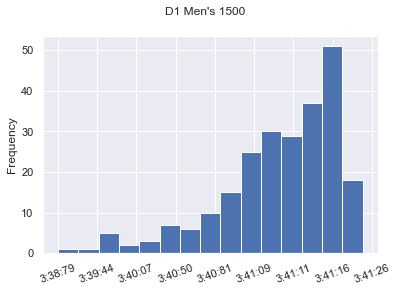

In [84]:
histogram_all_years(df100, 'D1', 'Men', '1500')

### Function that creates a dataframe with 
### min, average, median, max, std, and quintiles for TIME_SECS for each event across ALL years, division, sex, event

In [85]:
def events_desc(df, division, sex):
    '''Returns a dataframe with summary stats for TIME_SECS for each event for all years given division and sex'''
    series_list = []
    for event in df.EVENT.unique():
        df_desc = df[(df['DIVISION'] == division) & (df100['SEX'] == sex) & (df100['EVENT'] == event)].TIME_SECS.describe(percentiles=[0.2, 0.4, 0.6, 0.8])
        series_list.append(df_desc)
    result = pd.DataFrame(series_list, index=df100.EVENT.unique())
    return result

In [86]:
D2women_desc = events_desc(df100, 'D3', 'Women')
D2women_desc.head()

count         mean        std      min       20%       40%      50%  \
100    240.0    12.016750   0.140696    11.41    11.938    12.000    12.03   
10000  240.0  2151.882875  30.667254  2024.06  2131.024  2150.556  2158.00   
100H   240.0    14.378250   0.210871    13.64    14.208    14.350    14.41   
110H     0.0          NaN        NaN      NaN       NaN       NaN      NaN   
1500   240.0   271.145542   3.238117   255.77   268.882   271.090   271.71   

            60%       80%      max  
100      12.060    12.130    12.32  
10000  2164.062  2176.416  2202.20  
100H     14.450    14.540    14.89  
110H        NaN       NaN      NaN  
1500    272.280   273.470   276.51

### Lets look at descriptive statistics for TIME_SECS and do some statistical hypothesis testing. 

In [87]:
event_means = df100.groupby(['CHAMP_YEAR', 'DIVISION', 'SEX', 'EVENT']).TIME_SECS.mean()
event_means.head()

CHAMP_YEAR  DIVISION  SEX  EVENT
2010        D1        Men  100        10.191250
                           10000    1721.702083
                           110H       13.682500
                           1500      221.196667
                           200        20.593333
Name: TIME_SECS, dtype: float64

In [88]:
# mean for event in 2021
def mean_event_2021(division, sex, event):
    '''Returns the averagze TIME_SECS for given division sex and event in year 2021'''
    return df100_2021[(df100_2021['DIVISION'] == division) & (df100_2021['SEX'] == sex) & (df100_2021['EVENT'] == event)].TIME_SECS.mean()

In [89]:
def event_desc_each_year(df, division, sex, event):
    '''Returns a dataframe of summary stats of TIME_SECS for each year for given division, sex and event.  
    Plots a regplot with 95% confidence interval for 2010-2019 mean observations in blue and the 2021 mean observation in red.'''
    
    series_list = []
    for year in df.CHAMP_YEAR.unique():
        df_desc = df[(df['CHAMP_YEAR'] == year) & (df['DIVISION'] == division) & (df['SEX'] == sex) & (df['EVENT'] == event)].TIME_SECS.describe(percentiles=[0.2, 0.4, 0.6, 0.8])        
        series_list.append(df_desc)
        
    result = pd.DataFrame(series_list, index=df.CHAMP_YEAR.unique())
    result['CONVERT'] = [convert_seconds(x) for x in result['mean']]
    
    # plot
    fig, ax = plt.subplots()
    plot = sns.regplot(data = result.reset_index(), x = 'index', y = 'mean', ci=95).set_title(division + ' ' + sex + '\'s ' + event)
    plot.yticks=result['CONVERT']
    
    plt.gcf().set_size_inches(10,6)
    
    # add 2021 mean datapoint to plot as a red dot
    plt.scatter(x=2021, y=mean_event_2021(division, sex, event), color='r')
    return result

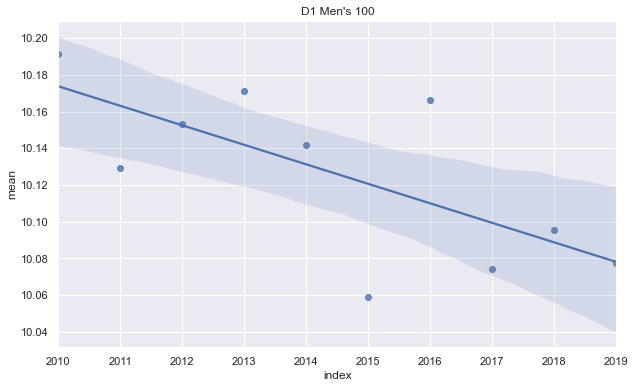

In [90]:
df_descD1men1500 = event_desc_each_year(df100, 'D1', 'Men', '100')

### Take a look at every event for a given division and sex.

In [91]:
def regplots(division, sex):
    '''Create a regplot for 2019 mean times in blue and 2021 mean in red for given division and sex'''
    for event in df100.EVENT.unique():
        if sex == 'Men':
            if event in men_running_events:
                event_desc_each_year(df100_not2021, division, sex, event)
        else: 
            if event in women_running_events:
                event_desc_each_year(df100_not2021, division, sex, event)

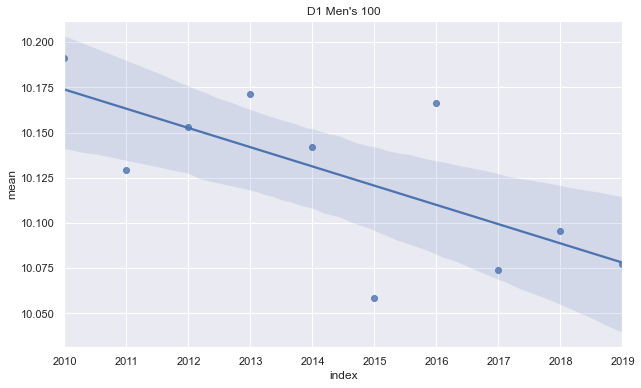

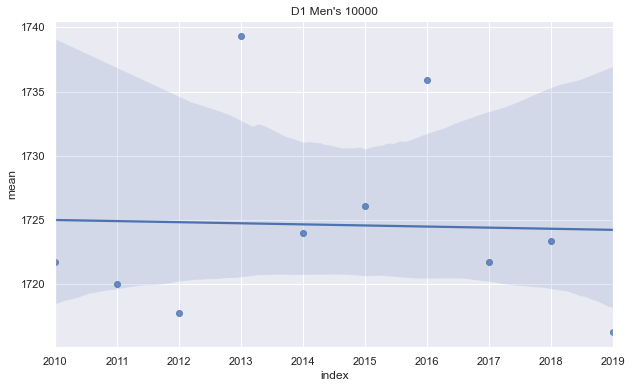

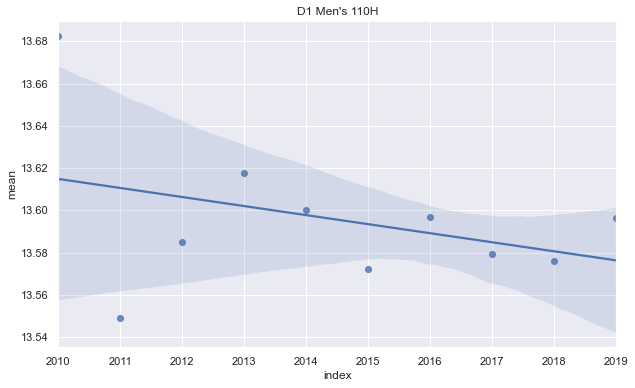

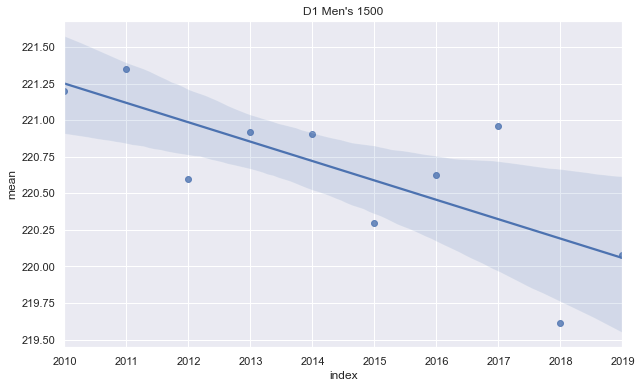

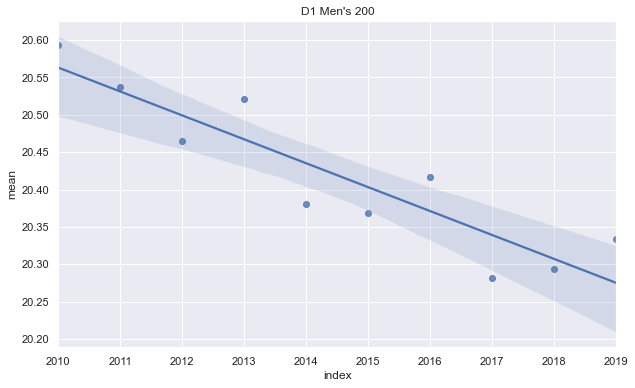

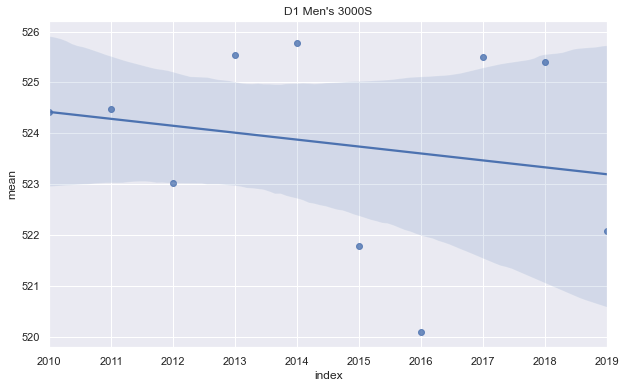

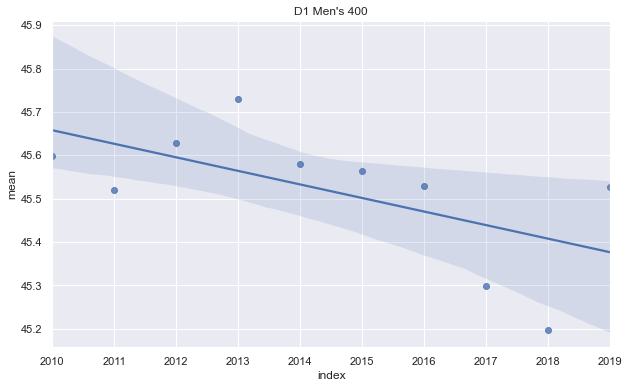

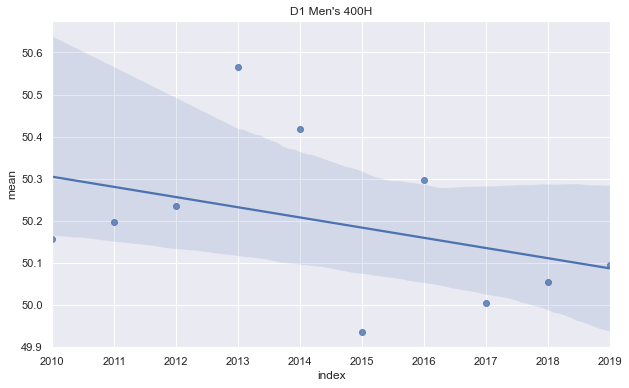

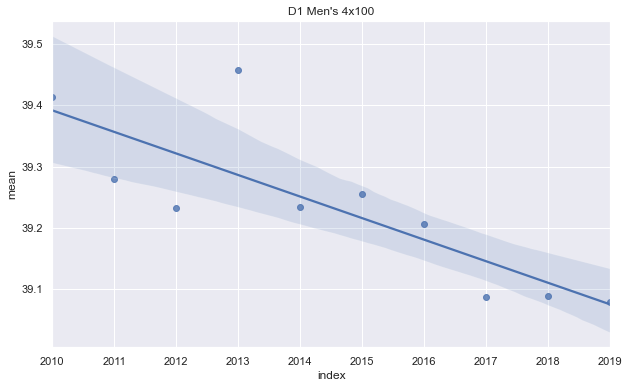

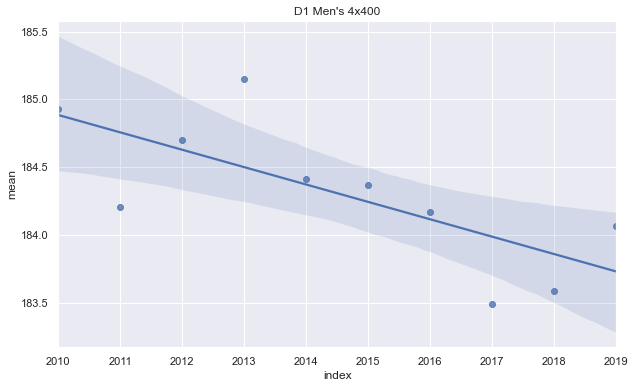

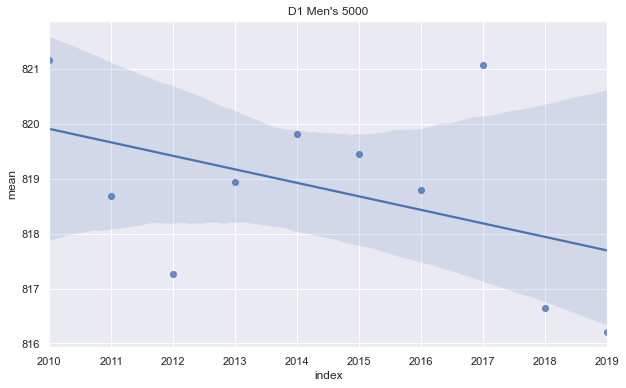

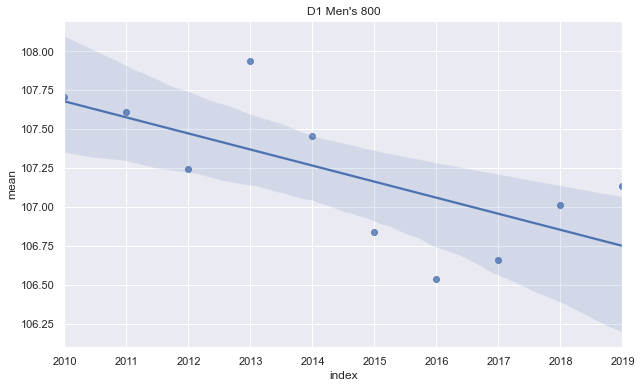

In [92]:
d1men = regplots('D1', 'Men')

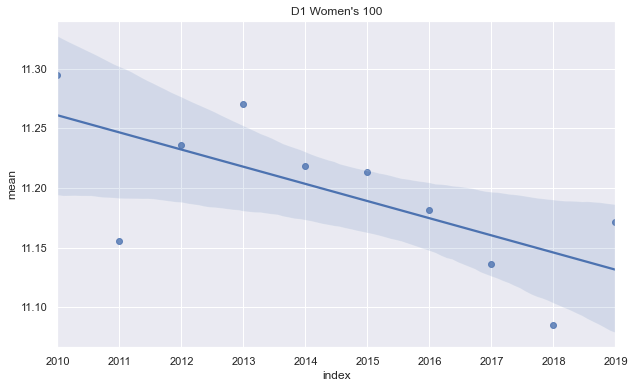

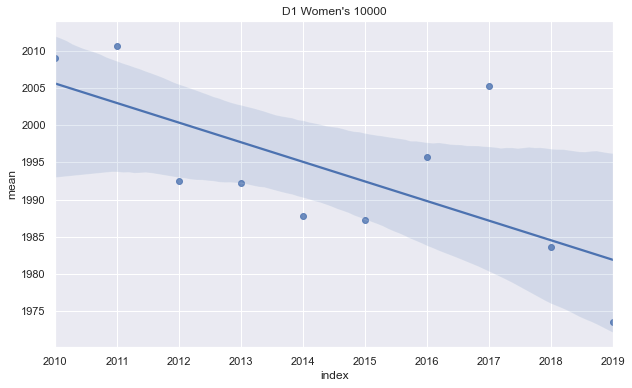

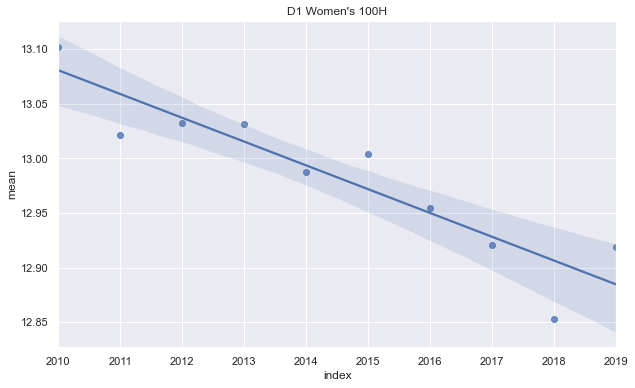

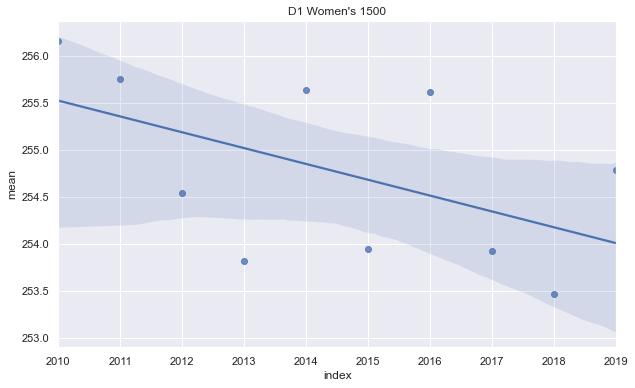

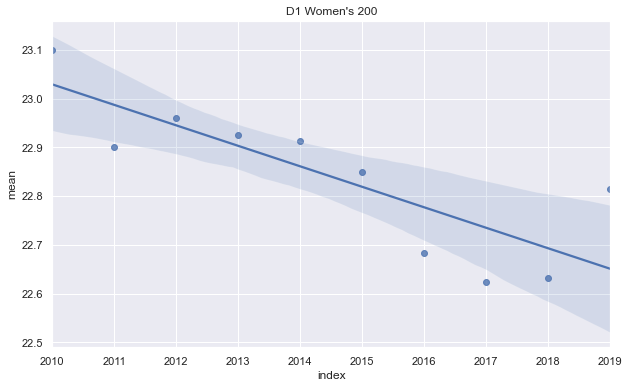

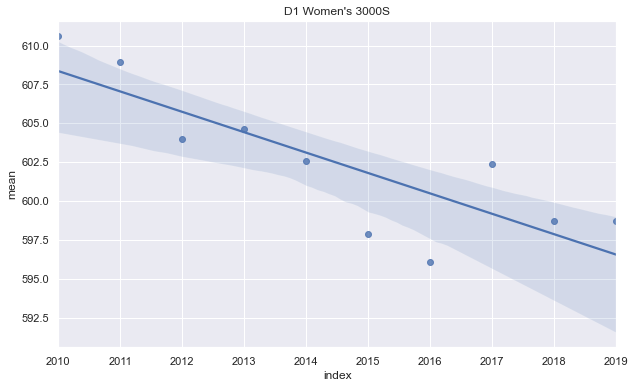

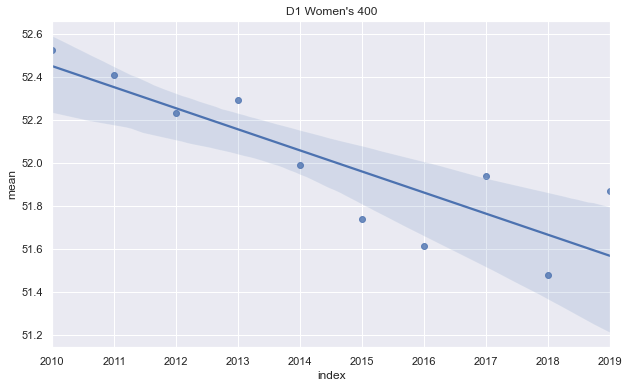

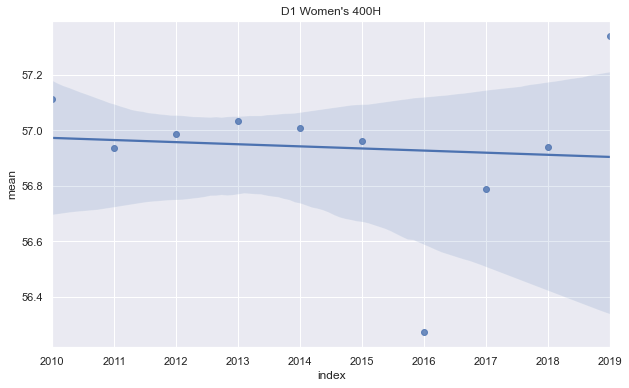

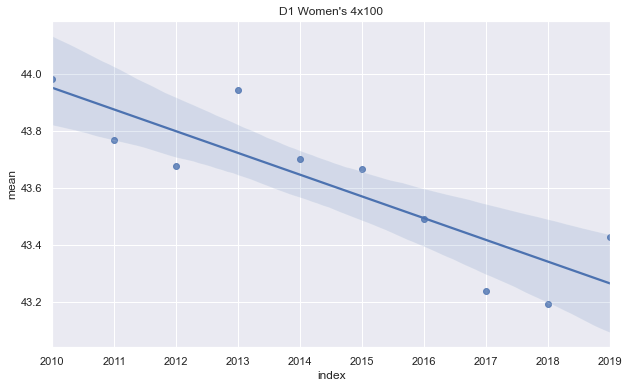

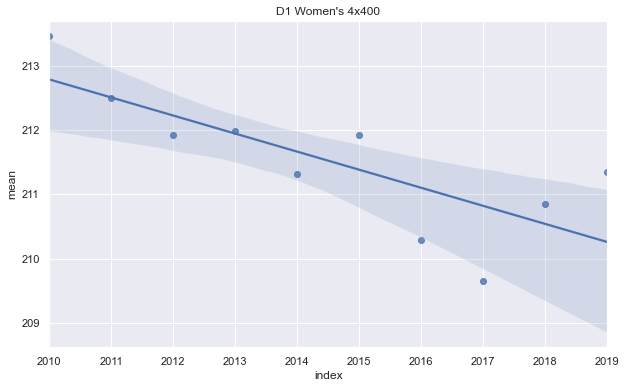

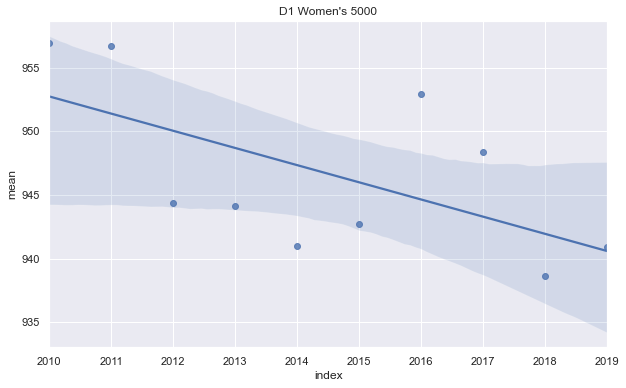

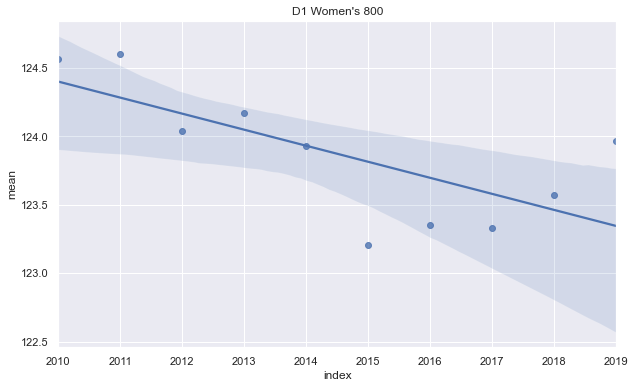

In [93]:
d1women = regplots('D1', 'Women')

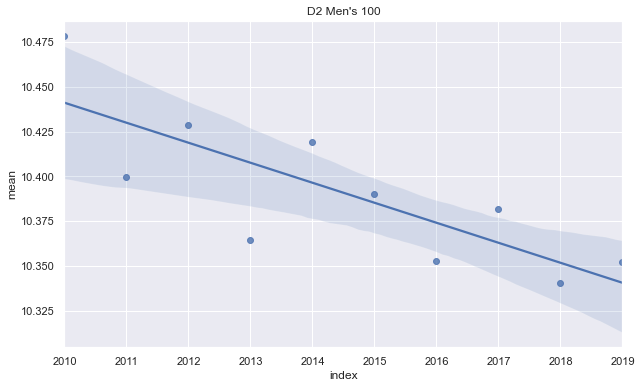

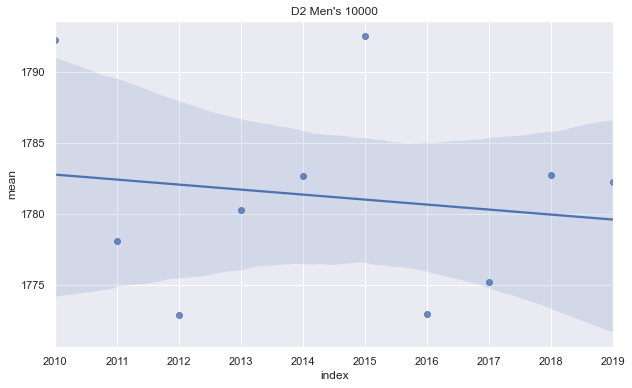

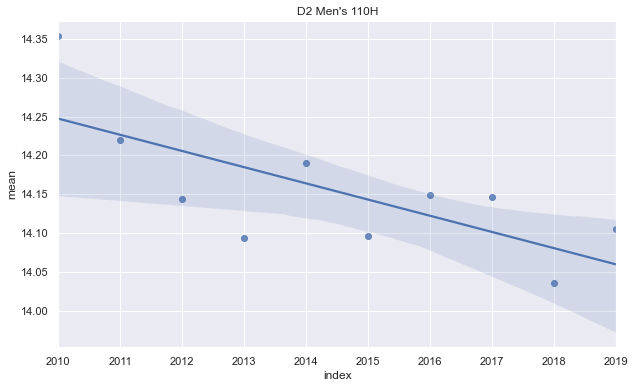

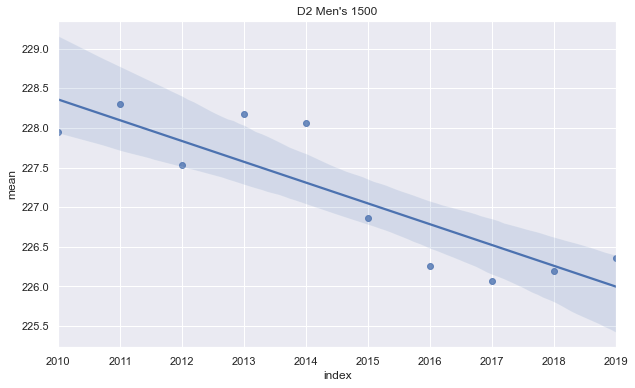

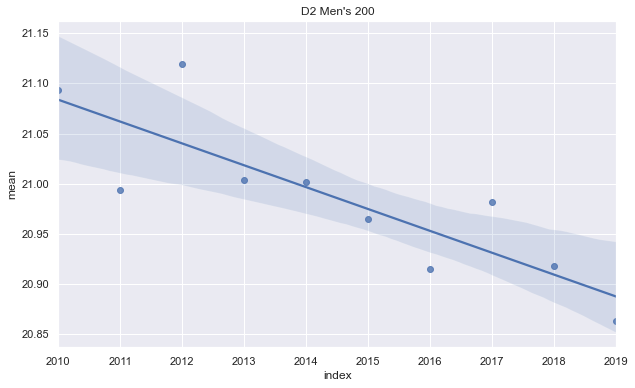

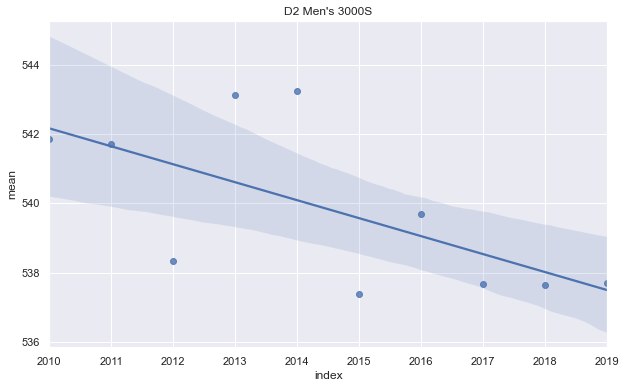

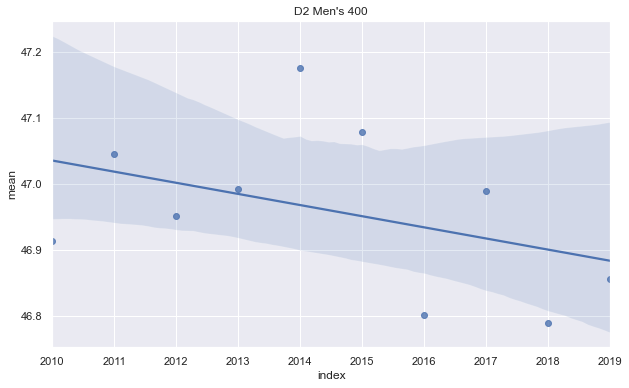

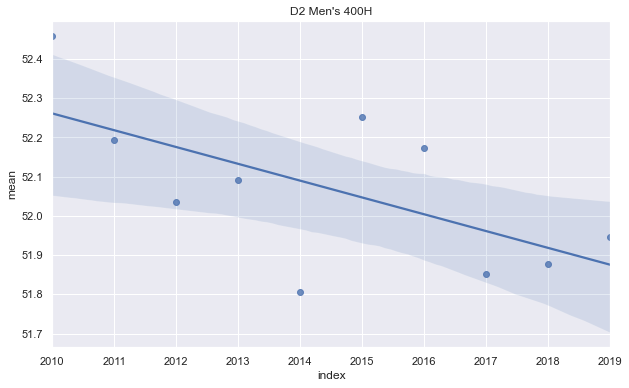

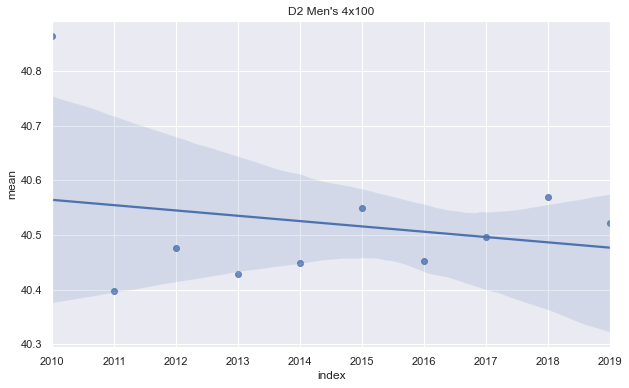

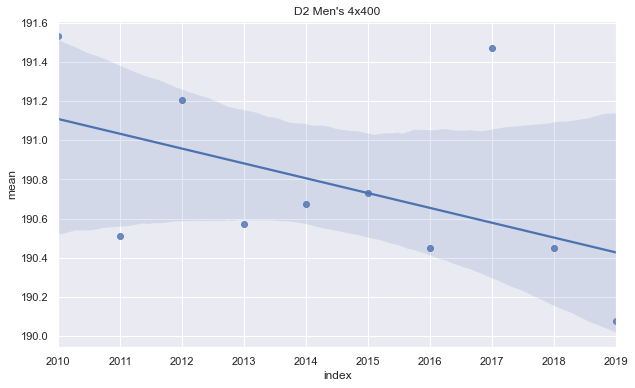

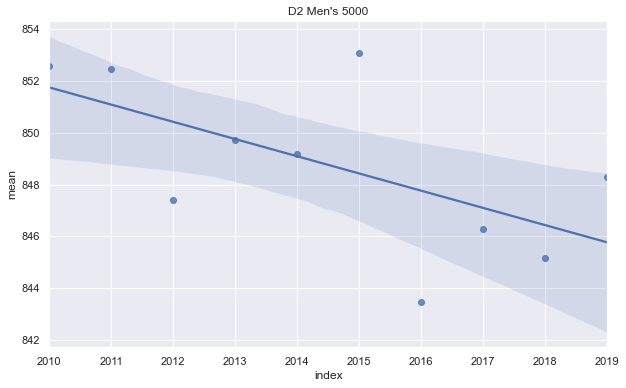

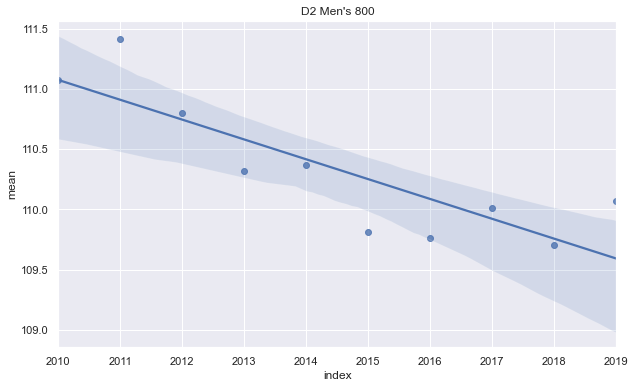

In [94]:
d2men = regplots('D2', 'Men')

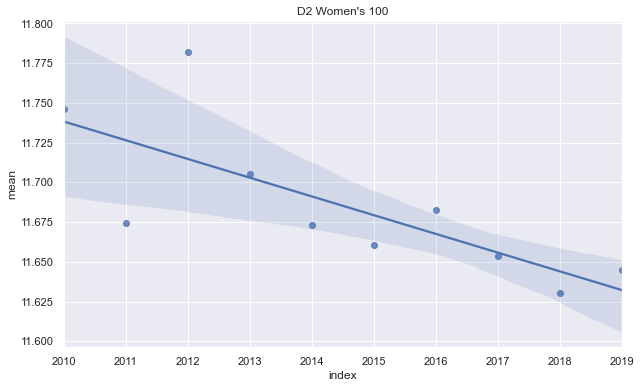

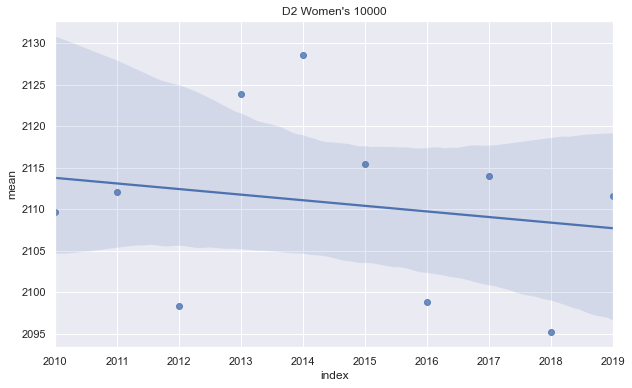

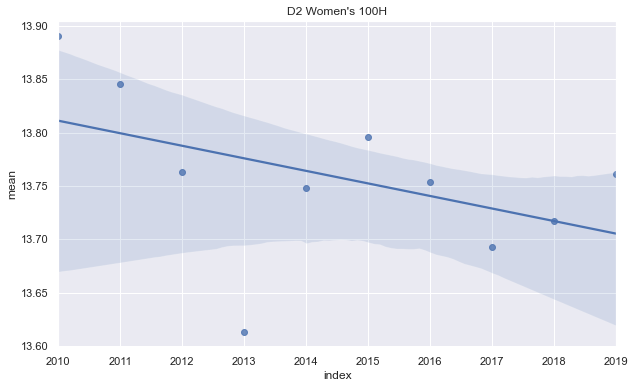

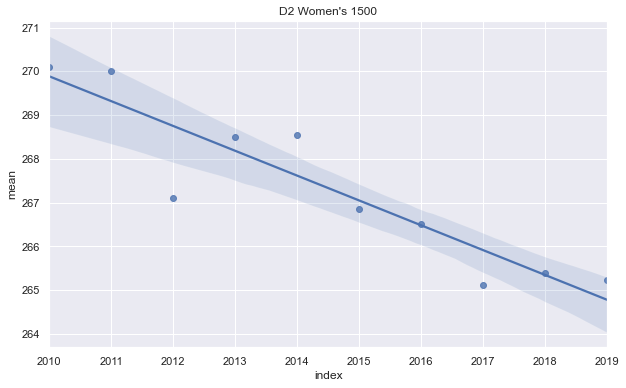

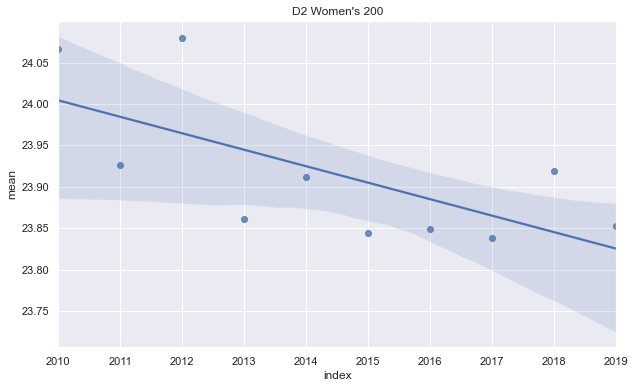

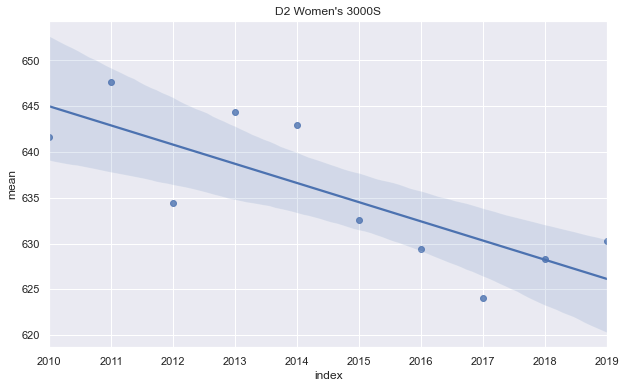

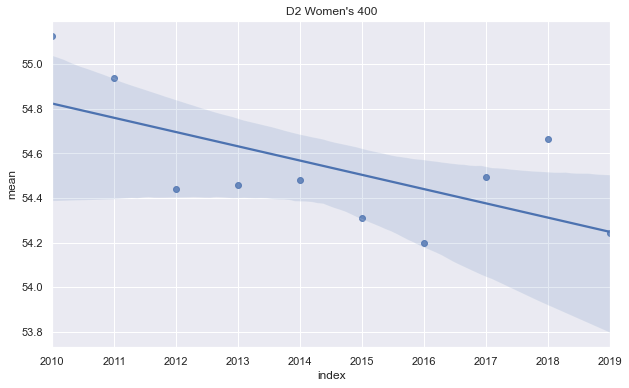

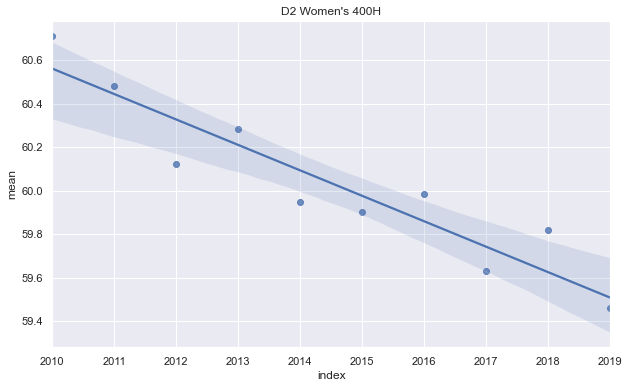

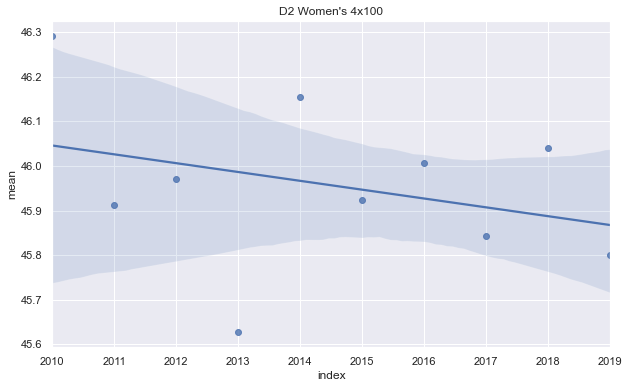

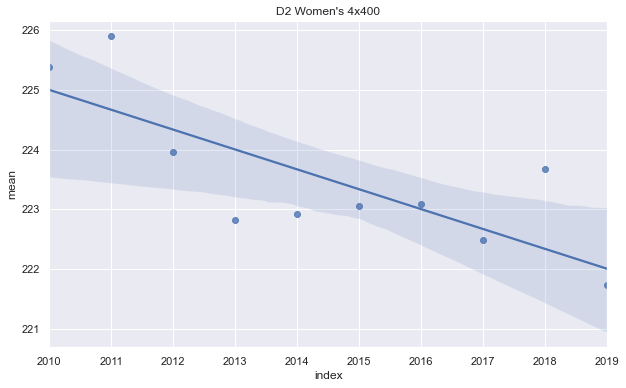

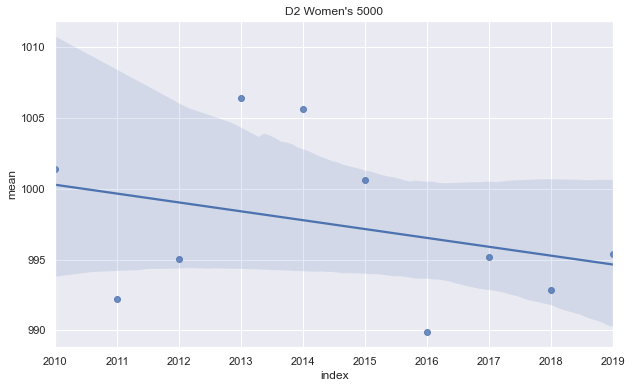

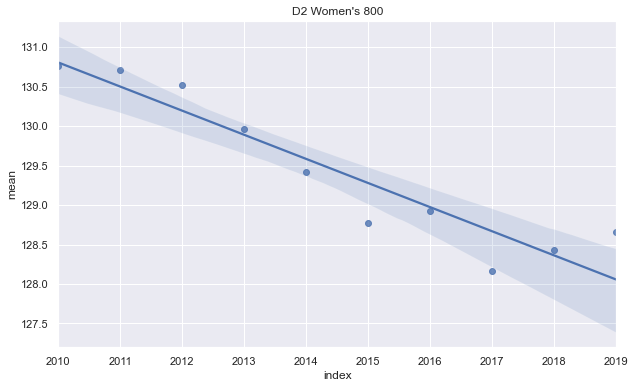

In [95]:
d2women = regplots('D2', 'Women')

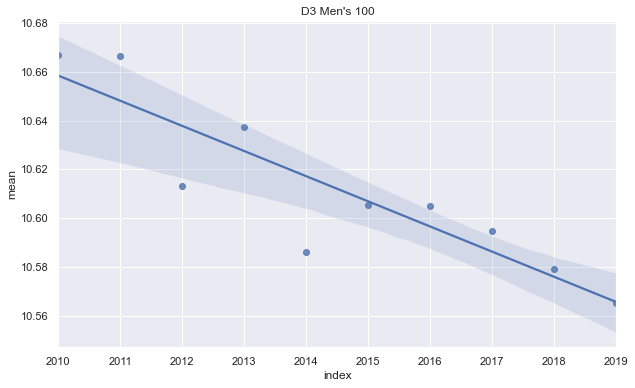

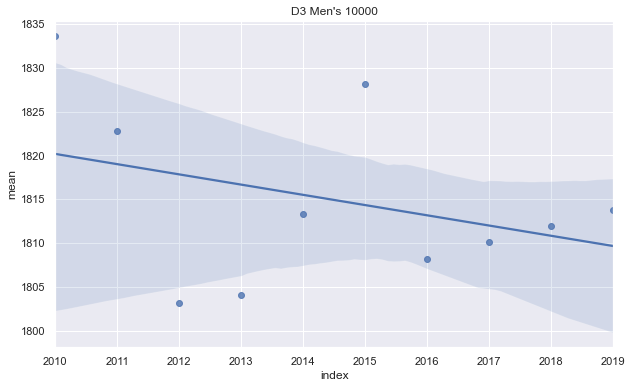

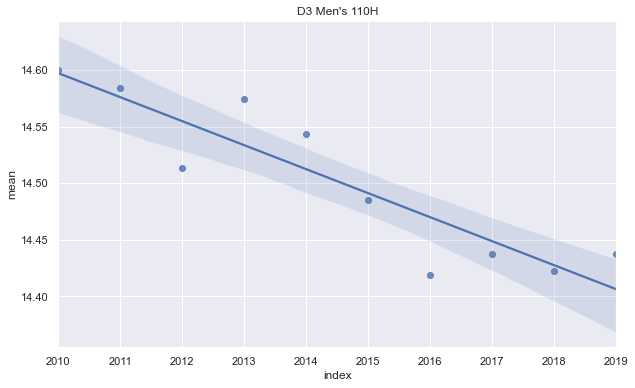

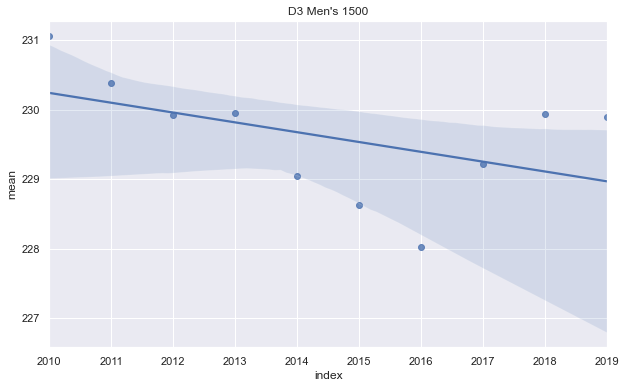

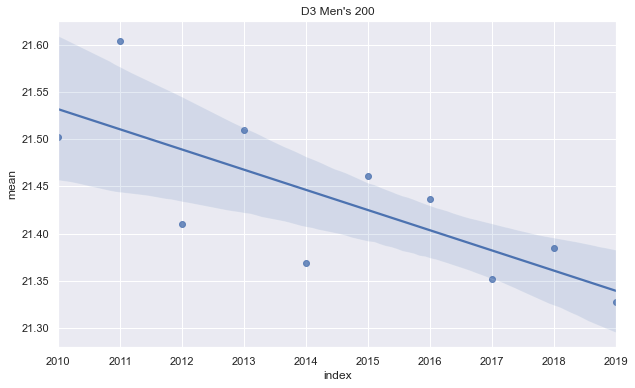

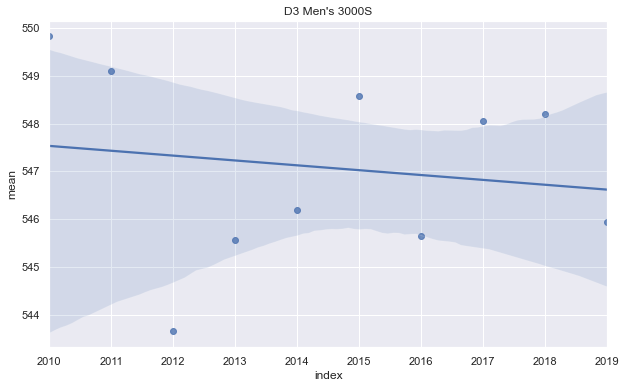

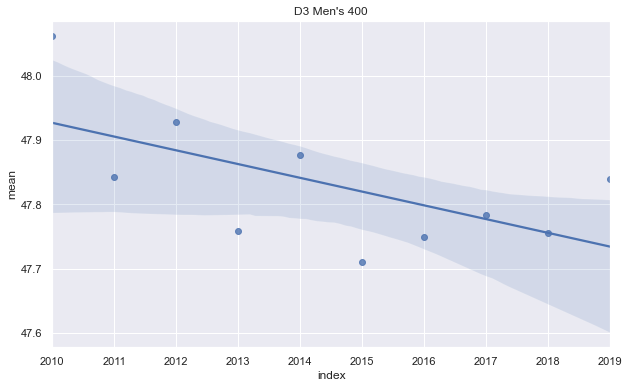

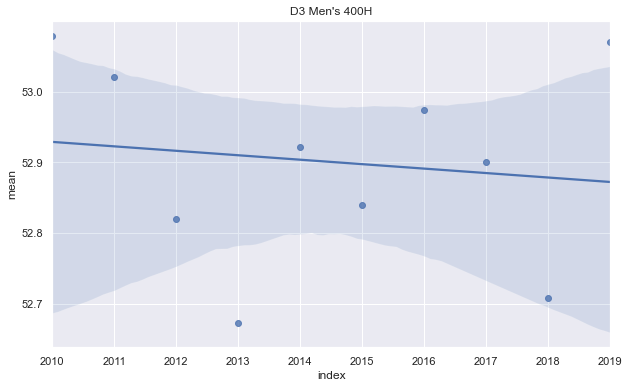

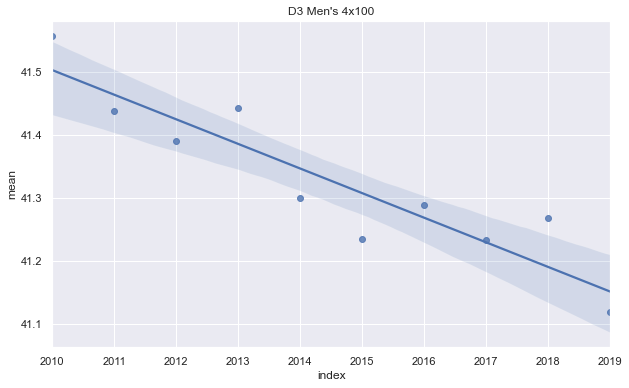

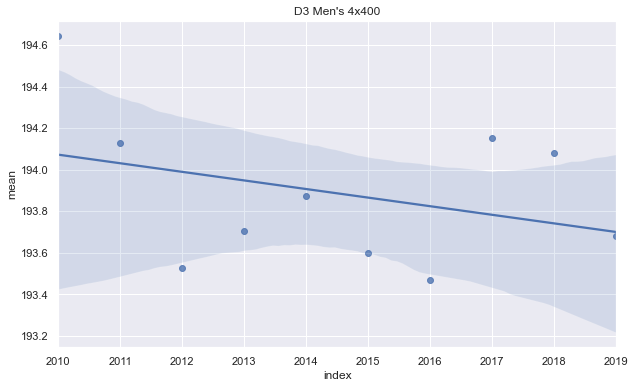

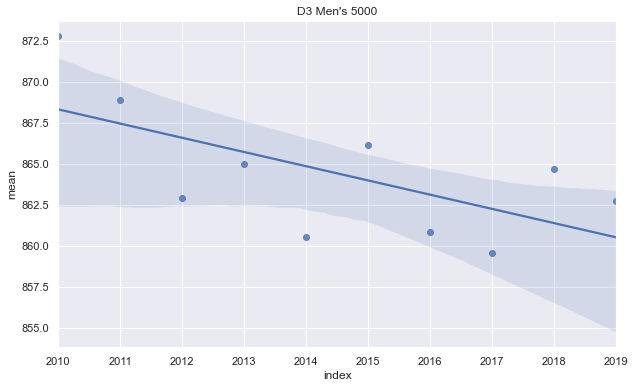

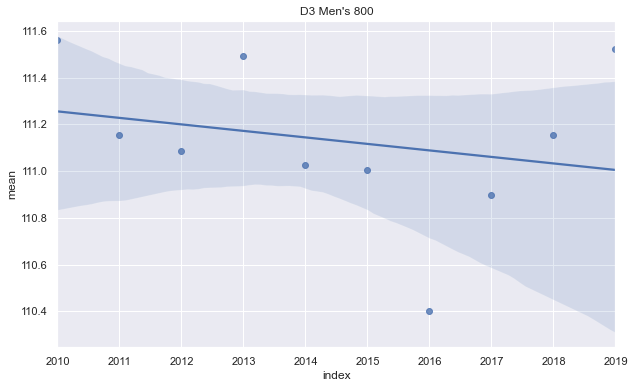

In [96]:
d3men = regplots('D3', 'Men')

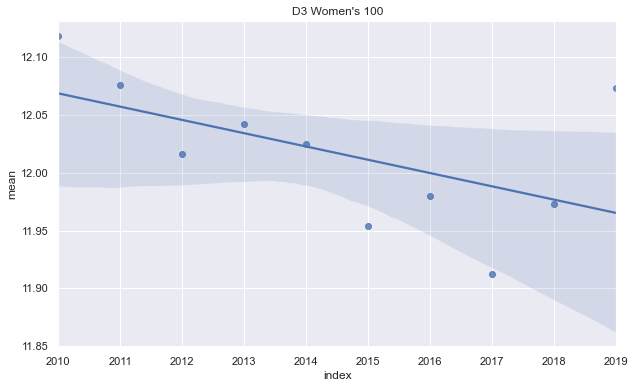

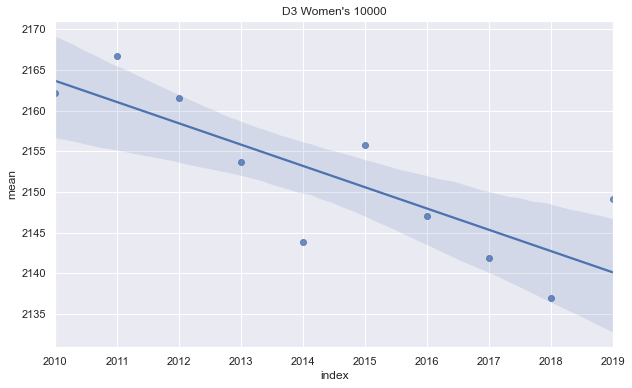

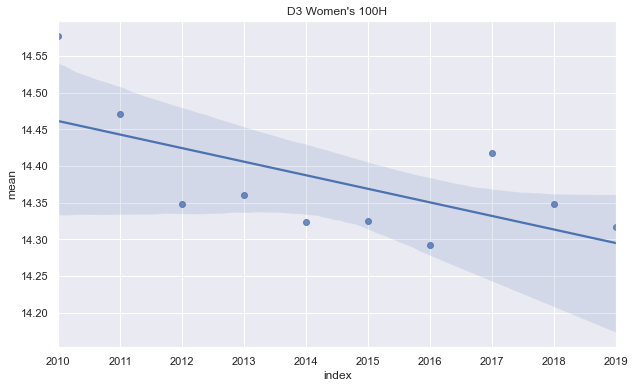

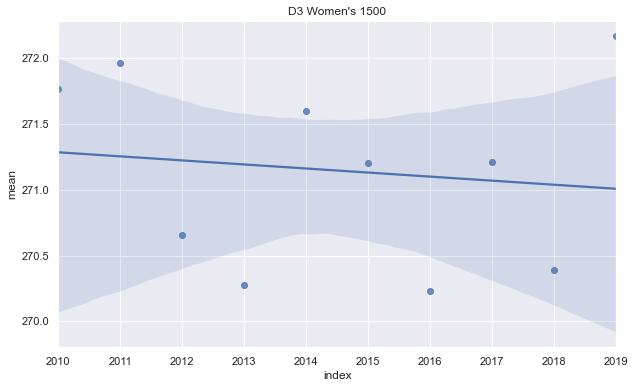

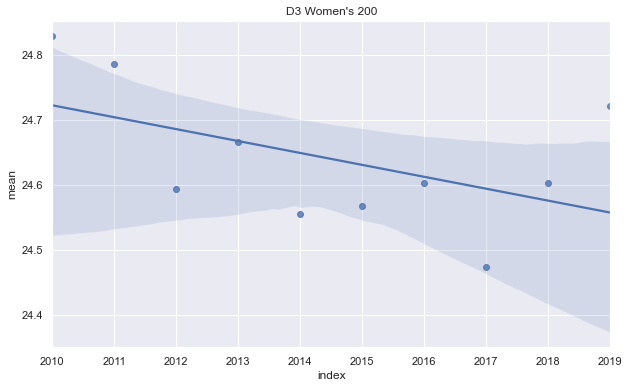

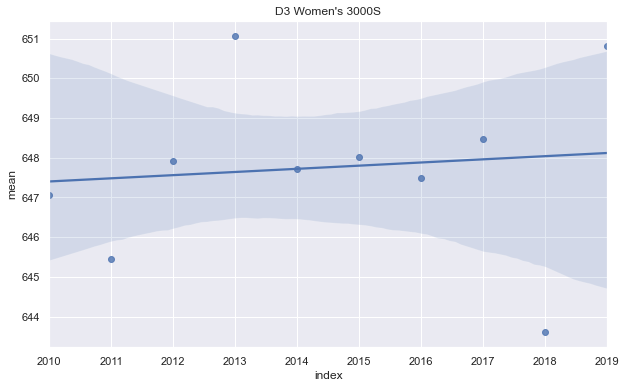

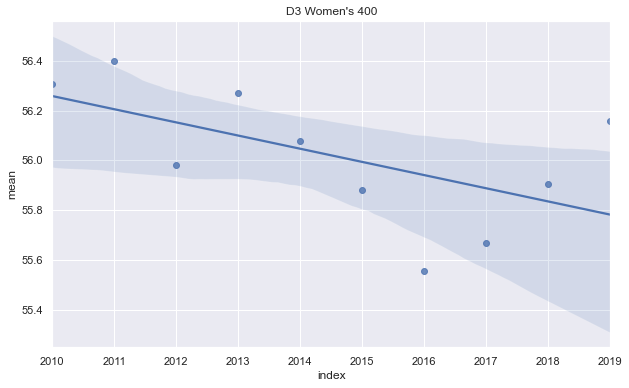

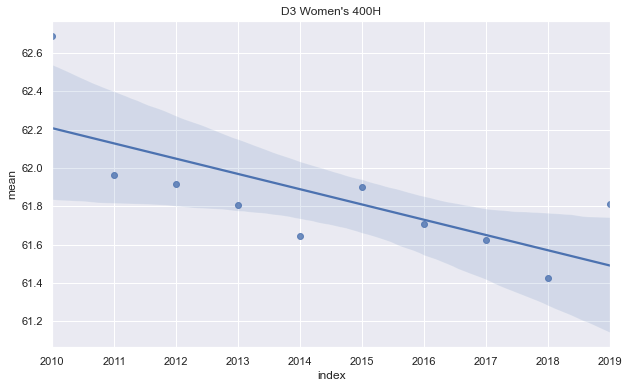

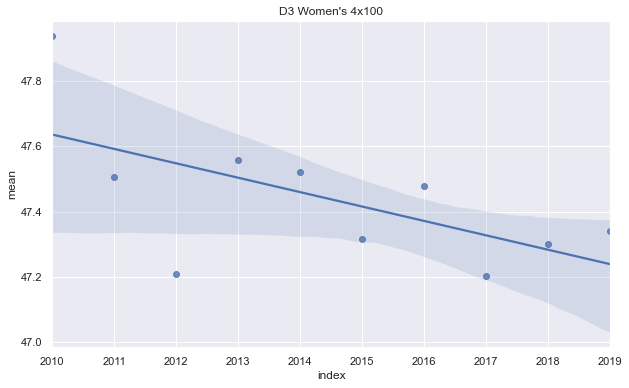

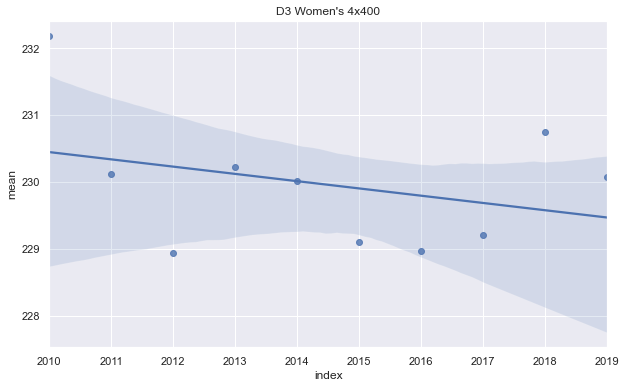

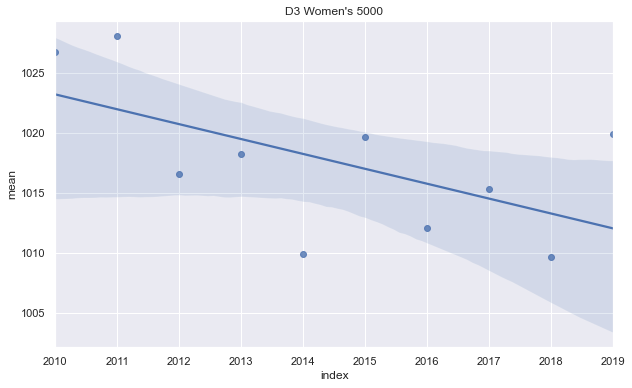

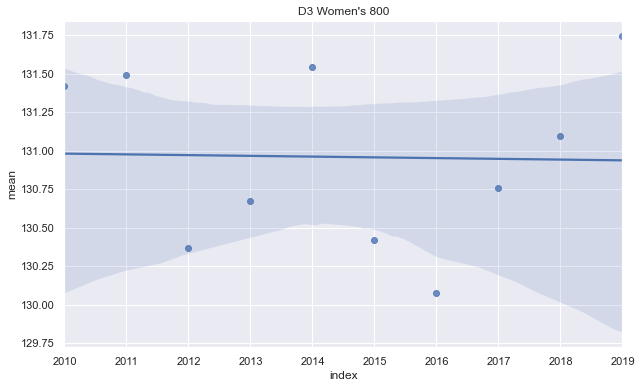

In [97]:
d3women = regplots('D3', 'Women')

### Make DF with mean time for each year by group (DIVISION/EVENT/SEX)

In [98]:
df_list = [g for _,g in df100.groupby(['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX'])]

In [99]:
means_list = [[i.iloc[0].CHAMP_YEAR, i.iloc[0].DIVISION, i.iloc[0].SEX, i.iloc[0].EVENT, i.TIME_SECS.mean()] for i in df_list]

In [100]:
groups = [means_list[i][1:4] for i in range(len(means_list))]

In [101]:
unique_groups = [item for index, item in enumerate(groups) if item not in groups[:index]]

In [102]:
unique_groups_flatten = [''.join(i) for i in unique_groups]

In [103]:
for name in unique_groups_flatten:
    exec('{} = pd.DataFrame()'.format(name))

In [104]:
means_list[0]

[2010, 'D1', 'Men', '100', 10.191250000000002]

In [105]:
# histogram for results for given division, sex, event and all years

def histogram_all_years_NORM(df, division, sex, event):
    '''Takes a queried dataframe and combines all NORM_TIME for that given division sex and event across all years'''
    
    df_graph = query_all_years(df, division, sex, event)
    
    fig, ax = plt.subplots()
    plot = df_graph.NORM_TIME.plot(kind='hist', bins=15, grid=True, ax=ax)
    plt.xlabel('TIME_SECS / MEAN')
    pl.suptitle(str(df_graph.DIVISION.iloc[0] + ' ' + df_graph.SEX.iloc[0] + '\'s ' + df_graph.EVENT.iloc[0]))

AttributeError: 'DataFrame' object has no attribute 'NORM_TIME'

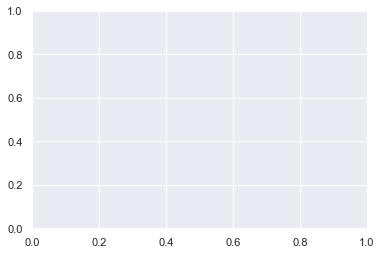

In [106]:
histogram_all_years_NORM(df100, 'D1', 'Men', '1500')

In [ ]:
# split off 2021 out into a separate dfs
df100_2021 = df100[df100['CHAMP_YEAR'] == 2021]
df100_not2021 = df100[df100['CHAMP_YEAR'] != 2021]

In [ ]:
df100_2021.head()

In [ ]:
df100_not2021.CHAMP_YEAR.unique()

In [ ]:
means = [(year, df100_not2021[(df100_not2021['CHAMP_YEAR'] == year) & (df100_not2021['DIVISION'] == 'D1') & (df100_not2021['SEX'] == 'Men') & (df100_not2021['EVENT'] == '1500')].NORM_TIME.mean()) for year in df100_not2021.CHAMP_YEAR.unique()]

In [ ]:
means

In [ ]:
mean_2021 = df100_not2021[(df100_not2021['DIVISION'] == 'D1') & (df100_not2021['SEX'] == 'Men') & (df100_not2021['EVENT'] == '1500')].NORM_TIME.mean()

In [ ]:
plot = plt.scatter(*zip(*means))
plot = plt.scatter(x=2021, y=mean_2021, color='r')

### DUMMIES for fixed effects

In [ ]:
# create dummy dfs for each variable
champ_year_dummy = pd.get_dummies(df100['CHAMP_YEAR'])
division_dummy = pd.get_dummies(df100['DIVISION'])
event_dummy = pd.get_dummies(df100['EVENT'])
sex_dummy = pd.get_dummies(df100['SEX'])

In [ ]:
# concat dummy dfs to right side of df100
df100 = pd.concat([df100, champ_year_dummy, division_dummy, event_dummy, sex_dummy], axis=1)

In [ ]:
dftest = df100.copy(deep=False)

### Specify Model

In [ ]:
model = 'NORM_TIME ~ DISTANCE + AFTER2021 + DISTANCE * AFTER2021 + CHAMP_YEAR + DIVISION + SEX'

In [ ]:
# DiD specification with clustered standard errors 
mod = smf.ols(formula=model, data=dftest)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': dftest['CHAMP_YEAR']},use_t=True)
print(res.summary())